1. Setup and Data Loading

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for pandas DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

TRACE_NAMES = [
    "Coding",
    "Conversation",
]
TRACE_FILENAMES = [
    "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_code_1week.csv",
    "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_conv_1week.csv",
]

df_traces = {}
for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
    print(f"Loading {trace_name} trace from {trace_filename}...")
    # We need to use mixed format because we have both:
    # 2024-05-12 00:00:00.001163+00:00 and 2024-05-12 00:00:00+00:00
    # This is pretty expensive and there are probably better ways to handle this
    df_traces[trace_name] = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"], date_format="mixed", dayfirst=False)
    print(f"Successfully loaded {trace_name} trace. Shape: {df_traces[trace_name].shape}")

print("\n--- Initial DataFrames ---")
print("Coding Trace Head:")
print(df_traces["Coding"].head())
print("\nConversation Trace Head:")
print(df_traces["Conversation"].head())

Loading Coding trace from https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_code_1week.csv...
Successfully loaded Coding trace. Shape: (16803695, 3)
Loading Conversation trace from https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_conv_1week.csv...
Successfully loaded Conversation trace. Shape: (27303999, 3)

--- Initial DataFrames ---
Coding Trace Head:
                         TIMESTAMP  ContextTokens  GeneratedTokens
0 2024-05-10 00:00:00.009930+00:00           2162                5
1 2024-05-10 00:00:00.017335+00:00           2399                6
2 2024-05-10 00:00:00.022314+00:00             76               15
3 2024-05-10 00:00:00.037845+00:00           2376                1
4 2024-05-10 00:00:00.083890+00:00           7670                8

Conversation Trace Head:
                         TIMESTAMP  ContextTokens  GeneratedTokens
0 2024-05-12 00:00:00.001163+00:00        

2. Data Exploration (Initial Pass)
Now that the data is loaded, let's perform some initial checks to understand its structure and content.

In [6]:
print("\n--- Data Information and Statistics ---")

for trace_name, df in df_traces.items():
    print(f"\n--- {trace_name} Trace Info ---")
    df.info()
    print(f"\n--- {trace_name} Trace Description ---")
    print(df.describe())
    print(f"\n--- {trace_name} Trace Missing Values ---")
    print(df.isnull().sum())

# Check for time range and unique values
for trace_name, df in df_traces.items():
    print(f"\n--- {trace_name} Trace Time Range ---")
    print(f"Start Timestamp: {df['TIMESTAMP'].min()}")
    print(f"End Timestamp: {df['TIMESTAMP'].max()}")
    print(f"Duration: {df['TIMESTAMP'].max() - df['TIMESTAMP'].min()}")

    print(f"\n--- {trace_name} Trace Unique ContextTokens (first 10) ---")
    print(df['ContextTokens'].value_counts().head(10))
    print(f"\n--- {trace_name} Trace Unique GeneratedTokens (first 10) ---")
    print(df['GeneratedTokens'].value_counts().head(10))


--- Data Information and Statistics ---

--- Coding Trace Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16803695 entries, 0 to 16803694
Data columns (total 3 columns):
 #   Column           Dtype              
---  ------           -----              
 0   TIMESTAMP        datetime64[ns, UTC]
 1   ContextTokens    int64              
 2   GeneratedTokens  int64              
dtypes: datetime64[ns, UTC](1), int64(2)
memory usage: 384.6 MB

--- Coding Trace Description ---
       ContextTokens  GeneratedTokens
count   1.680370e+07     1.680370e+07
mean    2.511276e+03     2.268973e+01
std     2.133541e+03     7.478323e+01
min     1.000000e+00     1.000000e+00
25%     9.380000e+02     3.000000e+00
50%     1.930000e+03     8.000000e+00
75%     3.348000e+03     1.800000e+01
max     7.743000e+03     5.000000e+03

--- Coding Trace Missing Values ---
TIMESTAMP          0
ContextTokens      0
GeneratedTokens    0
dtype: int64

--- Conversation Trace Info ---
<class 'pandas.core.fr

3. Basic Feature Engineering

In [7]:
print("\n--- Feature Engineering ---")

for trace_name, df in df_traces.items():
    print(f"\nProcessing features for {trace_name} trace...")
    # Sort by timestamp to ensure proper time-series analysis
    df_traces[trace_name] = df.sort_values(by='TIMESTAMP').reset_index(drop=True)

    # Time-based features
    df_traces[trace_name]['HourOfDay'] = df['TIMESTAMP'].dt.hour
    df_traces[trace_name]['DayOfWeek'] = df['TIMESTAMP'].dt.dayofweek # Monday=0, Sunday=6
    df_traces[trace_name]['DayOfMonth'] = df['TIMESTAMP'].dt.day
    df_traces[trace_name]['WeekOfYear'] = df['TIMESTAMP'].dt.isocalendar().week.astype(int)

    # Combined Token feature
    df_traces[trace_name]['TotalTokens'] = df['ContextTokens'] + df['GeneratedTokens']

    # Display new features
    print(df_traces[trace_name].head())


--- Feature Engineering ---

Processing features for Coding trace...
                         TIMESTAMP  ContextTokens  GeneratedTokens  HourOfDay  \
0 2024-05-10 00:00:00.009930+00:00           2162                5          0   
1 2024-05-10 00:00:00.017335+00:00           2399                6          0   
2 2024-05-10 00:00:00.022314+00:00             76               15          0   
3 2024-05-10 00:00:00.037845+00:00           2376                1          0   
4 2024-05-10 00:00:00.083890+00:00           7670                8          0   

   DayOfWeek  DayOfMonth  WeekOfYear  TotalTokens  
0          4          10          19         2167  
1          4          10          19         2405  
2          4          10          19           91  
3          4          10          19         2377  
4          4          10          19         7678  

Processing features for Conversation trace...
                         TIMESTAMP  ContextTokens  GeneratedTokens  HourOfDay  \
0 2

4. Visualization of Key Features


--- Data Visualization ---

Generating plots for Coding trace...


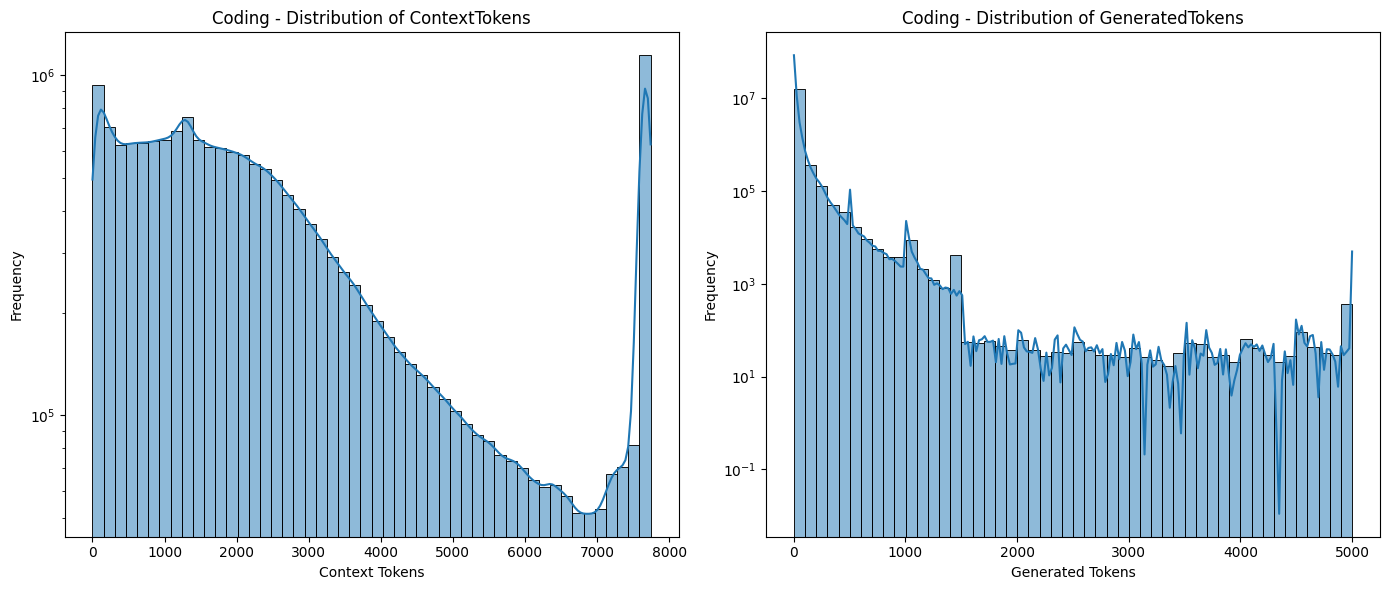

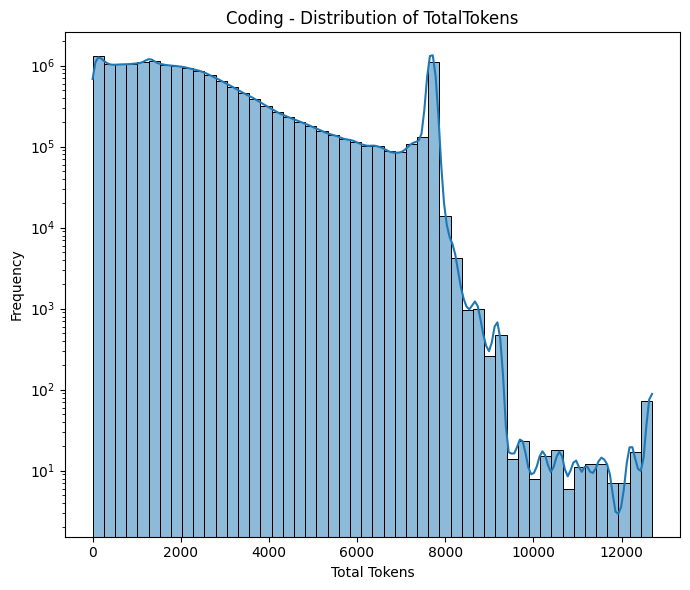

/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/871555424.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('TIMESTAMP').resample('H').size().reset_index(name='RequestCount')


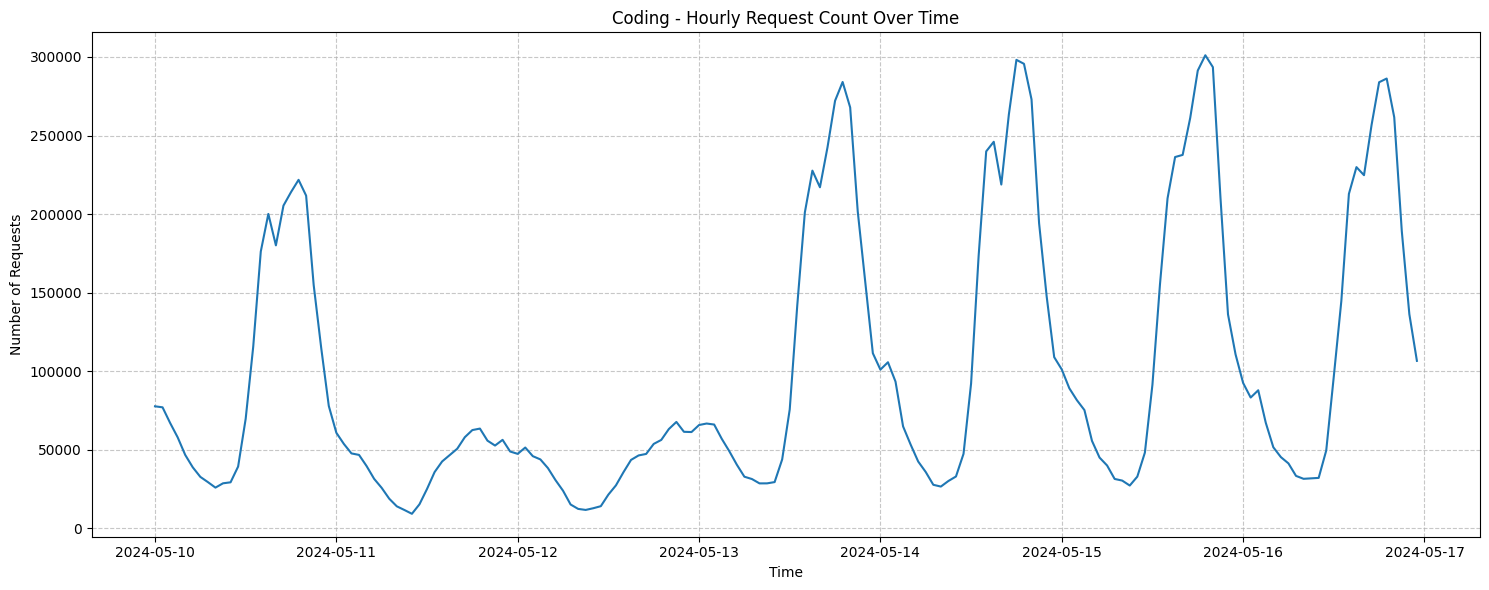

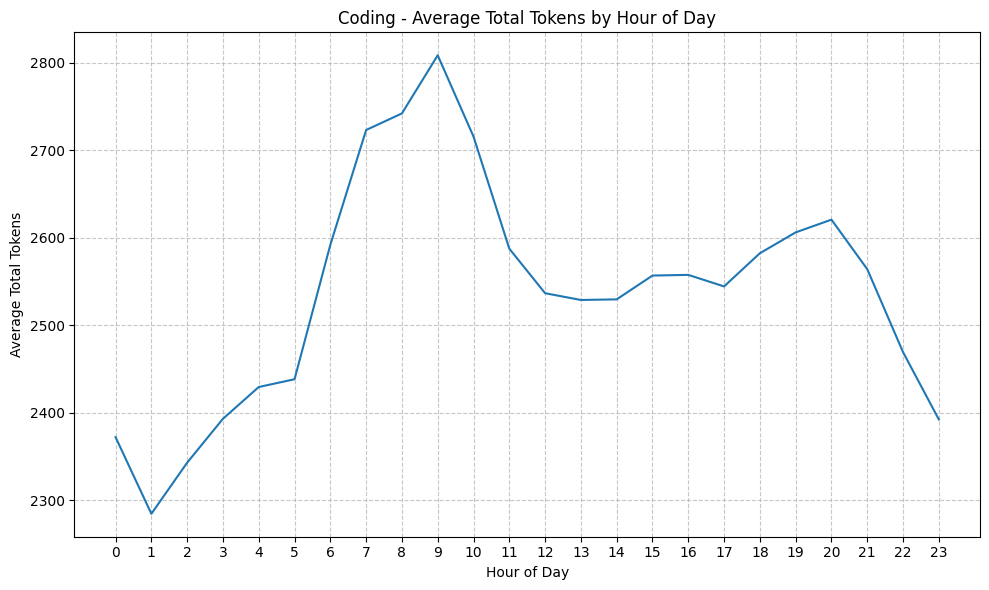

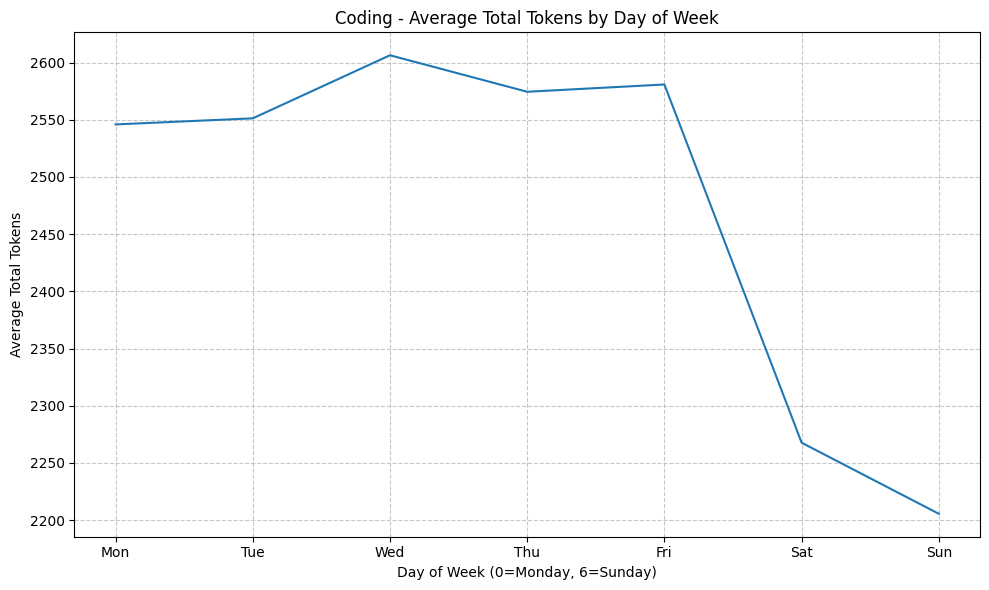


Generating plots for Conversation trace...


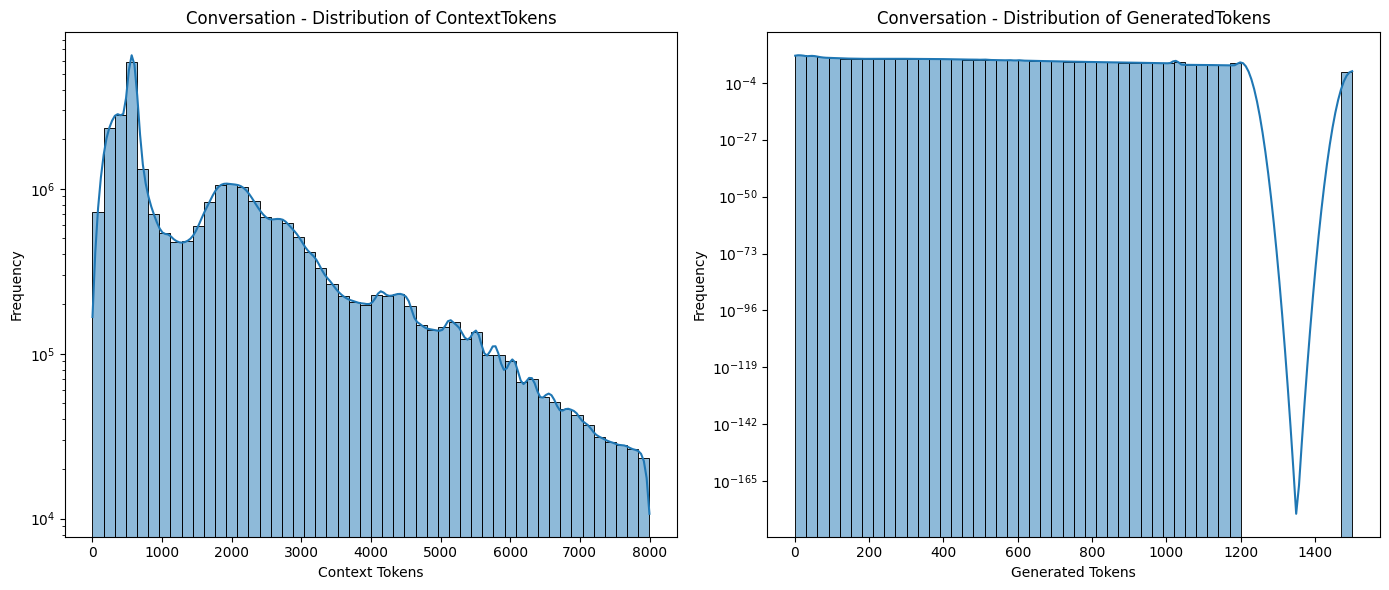

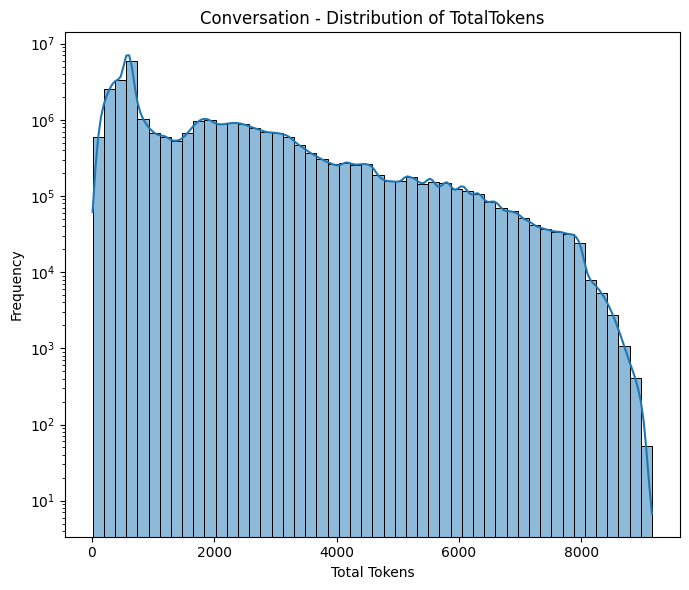

/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/871555424.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('TIMESTAMP').resample('H').size().reset_index(name='RequestCount')


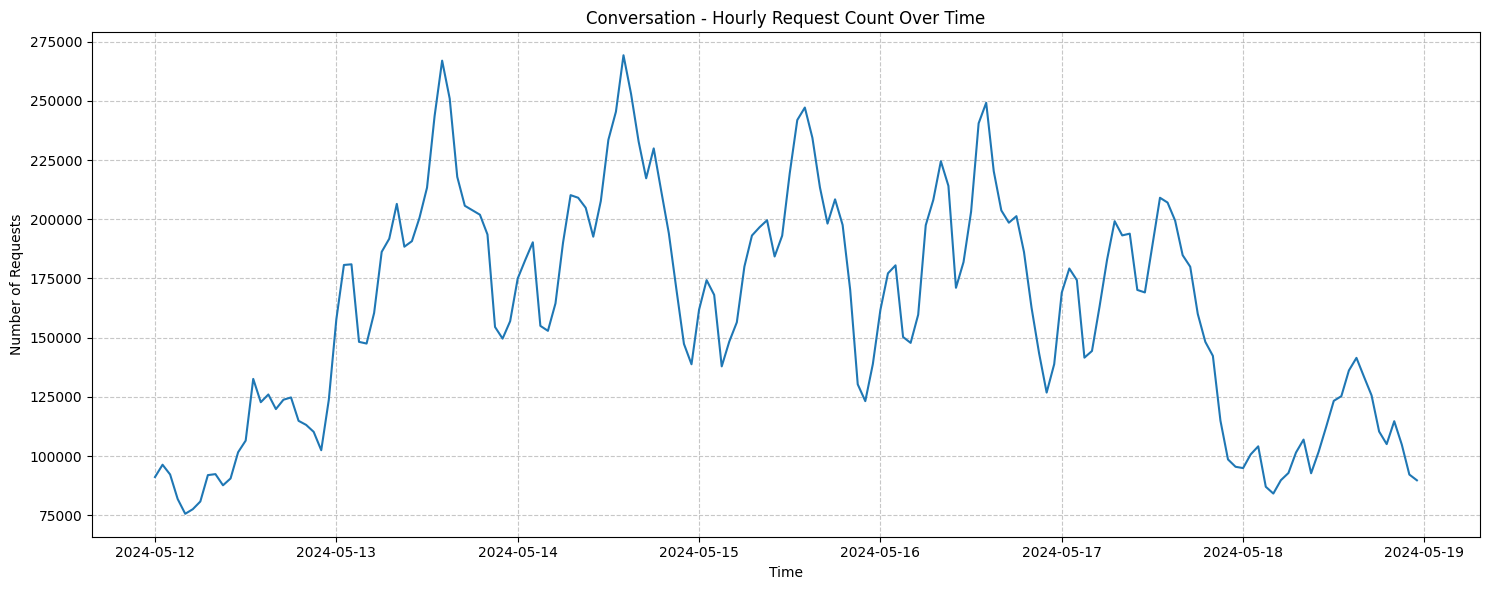

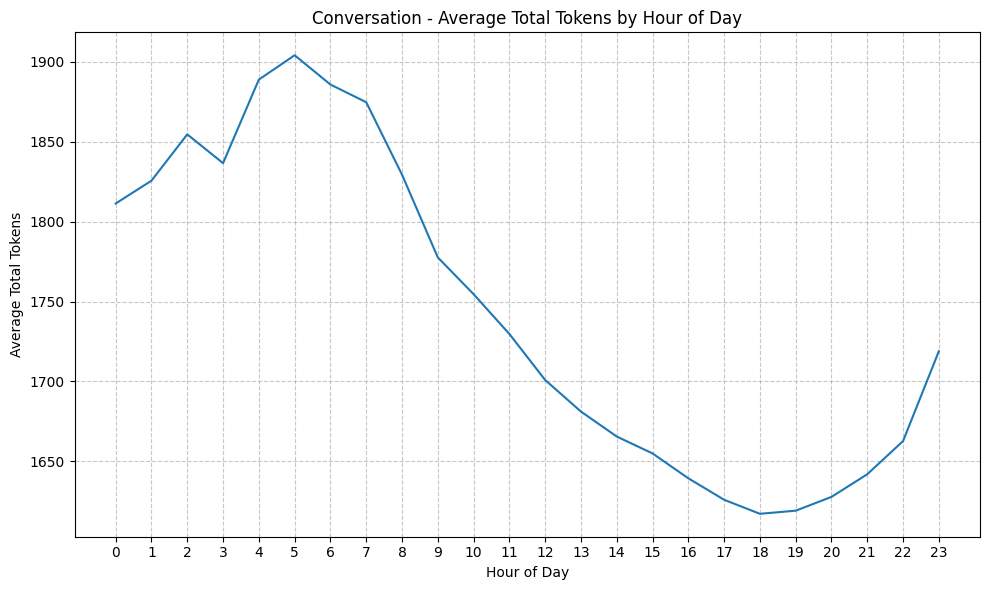

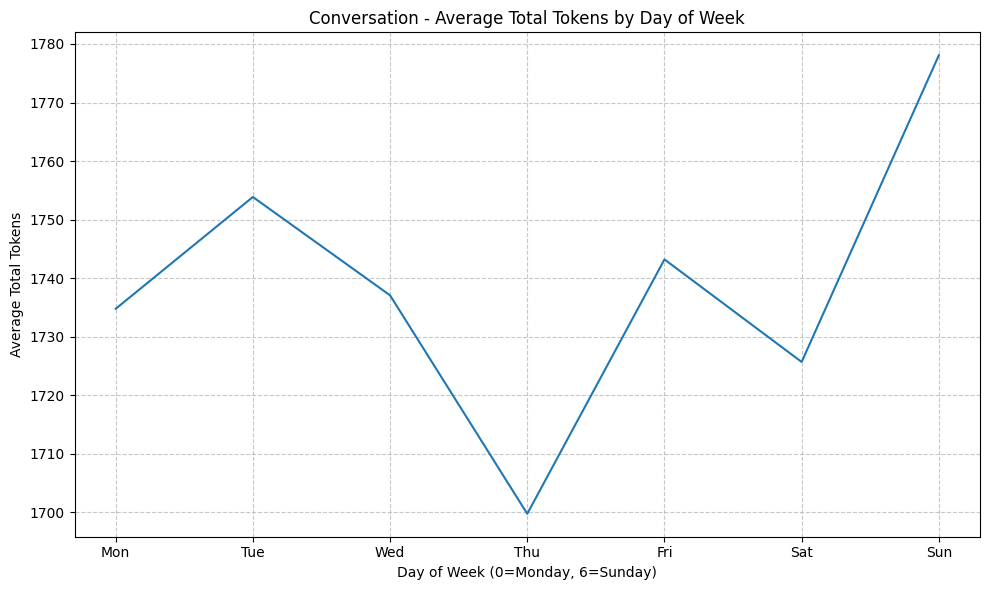

In [8]:
print("\n--- Data Visualization ---")

for trace_name, df in df_traces.items():
    print(f"\nGenerating plots for {trace_name} trace...")

    # Plot distribution of ContextTokens and GeneratedTokens
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['ContextTokens'], bins=50, kde=True)
    plt.title(f'{trace_name} - Distribution of ContextTokens')
    plt.xlabel('Context Tokens')
    plt.ylabel('Frequency')
    plt.yscale('log') # Use log scale due to heavy tail

    plt.subplot(1, 2, 2)
    sns.histplot(df['GeneratedTokens'], bins=50, kde=True)
    plt.title(f'{trace_name} - Distribution of GeneratedTokens')
    plt.xlabel('Generated Tokens')
    plt.ylabel('Frequency')
    plt.yscale('log') # Use log scale due to heavy tail
    plt.tight_layout()
    plt.show()

    # Plot distribution of TotalTokens
    plt.figure(figsize=(7, 6))
    sns.histplot(df['TotalTokens'], bins=50, kde=True)
    plt.title(f'{trace_name} - Distribution of TotalTokens')
    plt.xlabel('Total Tokens')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # Plot requests over time (e.g., requests per hour)
    # Resample to hourly frequency
    df_hourly = df.set_index('TIMESTAMP').resample('H').size().reset_index(name='RequestCount')
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_hourly, x='TIMESTAMP', y='RequestCount')
    plt.title(f'{trace_name} - Hourly Request Count Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Requests')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot average TotalTokens by Hour of Day
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df.groupby('HourOfDay')['TotalTokens'].mean().reset_index(), x='HourOfDay', y='TotalTokens')
    plt.title(f'{trace_name} - Average Total Tokens by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Total Tokens')
    plt.xticks(range(24))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot average TotalTokens by Day of Week
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df.groupby('DayOfWeek')['TotalTokens'].mean().reset_index(), x='DayOfWeek', y='TotalTokens')
    plt.title(f'{trace_name} - Average Total Tokens by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Average Total Tokens')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

5. Advanced Feature Engineering: Rolling Statistics and Lag Features

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Re-load data if running this code block independently, otherwise use existing df_traces
# (Assuming df_traces from previous steps is available in the environment)
# TRACE_NAMES = [ "Coding", "Conversation" ]
# TRACE_FILENAMES = [
#     "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_code_1week.csv",
#     "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_conv_1week.csv",
# ]
# df_traces = {}
# for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
#     df_traces[trace_name] = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"], date_format="mixed", dayfirst=False)
#     df_traces[trace_name] = df_traces[trace_name].sort_values(by='TIMESTAMP').reset_index(drop=True) # Ensure sorted for rolling/lag
#     df_traces[trace_name]['HourOfDay'] = df_traces[trace_name]['TIMESTAMP'].dt.hour
#     df_traces[trace_name]['DayOfWeek'] = df_traces[trace_name]['TIMESTAMP'].dt.dayofweek
#     df_traces[trace_name]['DayOfMonth'] = df_traces[trace_name]['TIMESTAMP'].dt.day
#     df_traces[trace_name]['WeekOfYear'] = df_traces[trace_name]['TIMESTAMP'].dt.isocalendar().week.astype(int)
#     df_traces[trace_name]['TotalTokens'] = df_traces[trace_name]['ContextTokens'] + df_traces[trace_name]['GeneratedTokens']


print("\n--- Advanced Feature Engineering: Rolling Statistics and Lag Features ---")

# Define time windows for rolling features (e.g., 5 min, 15 min, 1 hour)
time_windows = ['5min', '15min', '1H']

for trace_name, df in df_traces.items():
    print(f"\nProcessing advanced features for {trace_name} trace...")

    # Set TIMESTAMP as index for resampling and rolling operations
    df_temp = df.set_index('TIMESTAMP')

    # --- Rolling Statistics for TotalTokens ---
    for window in time_windows:
        df_temp[f'TotalTokens_rolling_mean_{window}'] = df_temp['TotalTokens'].rolling(window=window).mean().fillna(0)
        df_temp[f'TotalTokens_rolling_std_{window}'] = df_temp['TotalTokens'].rolling(window=window).std().fillna(0)
        # We fillna(0) for the initial periods where there aren't enough data points for the window
        # In a real-time system, these would be initialized or handled based on available history.

    # --- Request Count Rolling Statistics ---
    # First, resample to get request count per smaller interval (e.g., per second or per millisecond for the original granularity)
    # Then apply rolling on this count. Let's use 1-second granularity for resampling to get a count.
    # Note: If the timestamp differences are very small, direct rolling might be computationally intensive.
    # We will resample to a finer granularity like seconds for request count then apply rolling
    df_resampled_sec = df_temp.resample('1S').size().rename('RequestCount').to_frame()
    df_resampled_sec = df_resampled_sec.replace(np.nan, 0) # Fill periods with no requests

    for window in time_windows:
        df_resampled_sec[f'RequestCount_rolling_mean_{window}'] = df_resampled_sec['RequestCount'].rolling(window=window).mean().fillna(0)
        df_resampled_sec[f'RequestCount_rolling_std_{window}'] = df_resampled_sec['RequestCount'].rolling(window=window).std().fillna(0)

    # Merge rolling request counts back to the original dataframe
    # This requires merging on a resampled timestamp or using a join based on nearest time.
    # For simplicity and to avoid creating a massive dataframe from resampling,
    # let's calculate rolling features directly on the original `df_temp` using `expanding` for simpler aggregations or specific windows,
    # or by merging aggregated stats back.
    # A more practical approach is to calculate rolling statistics for *incoming requests*
    # rather than fixed time window aggregations which might be sparse due to high frequency data.

    # Let's reconsider rolling features on the original dataframe directly by count, not time.
    # This is more aligned with how an RL agent might observe state based on *recent requests*.
    rolling_counts = [5, 10, 20] # E.g., average over the last 5, 10, 20 requests

    for count in rolling_counts:
        df_temp[f'TotalTokens_last_{count}_mean'] = df_temp['TotalTokens'].rolling(window=count).mean().fillna(0)
        df_temp[f'TotalTokens_last_{count}_std'] = df_temp['TotalTokens'].rolling(window=count).std().fillna(0)
        df_temp[f'ContextTokens_last_{count}_mean'] = df_temp['ContextTokens'].rolling(window=count).mean().fillna(0)
        df_temp[f'GeneratedTokens_last_{count}_mean'] = df_temp['GeneratedTokens'].rolling(window=count).mean().fillna(0)


    # --- Lag Features ---
    # Lag the TotalTokens, ContextTokens, GeneratedTokens by 1 request.
    # This represents the characteristics of the immediately preceding request.
    df_temp['TotalTokens_lag_1'] = df_temp['TotalTokens'].shift(1).fillna(0)
    df_temp['ContextTokens_lag_1'] = df_temp['ContextTokens'].shift(1).fillna(0)
    df_temp['GeneratedTokens_lag_1'] = df_temp['GeneratedTokens'].shift(1).fillna(0)


    # Reset index to bring TIMESTAMP back as a column and store in df_traces
    df_traces[trace_name] = df_temp.reset_index()
    print(df_traces[trace_name].head())
    print(f"New shape for {trace_name}: {df_traces[trace_name].shape}")


--- Advanced Feature Engineering: Rolling Statistics and Lag Features ---

Processing advanced features for Coding trace...


/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_temp[f'TotalTokens_rolling_mean_{window}'] = df_temp['TotalTokens'].rolling(window=window).mean().fillna(0)
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_temp[f'TotalTokens_rolling_std_{window}'] = df_temp['TotalTokens'].rolling(window=window).std().fillna(0)
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled_sec = df_temp.resample('1S').size().rename('RequestCount').to_frame()
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:52: FutureWarning: 'H' is deprecated and will be removed in a future vers

                         TIMESTAMP  ContextTokens  GeneratedTokens  HourOfDay  \
0 2024-05-10 00:00:00.009930+00:00           2162                5          0   
1 2024-05-10 00:00:00.017335+00:00           2399                6          0   
2 2024-05-10 00:00:00.022314+00:00             76               15          0   
3 2024-05-10 00:00:00.037845+00:00           2376                1          0   
4 2024-05-10 00:00:00.083890+00:00           7670                8          0   

   DayOfWeek  DayOfMonth  WeekOfYear  TotalTokens  \
0          4          10          19         2167   
1          4          10          19         2405   
2          4          10          19           91   
3          4          10          19         2377   
4          4          10          19         7678   

   TotalTokens_rolling_mean_5min  TotalTokens_rolling_std_5min  \
0                    2167.000000                      0.000000   
1                    2286.000000                    168.291414

/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_temp[f'TotalTokens_rolling_mean_{window}'] = df_temp['TotalTokens'].rolling(window=window).mean().fillna(0)
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_temp[f'TotalTokens_rolling_std_{window}'] = df_temp['TotalTokens'].rolling(window=window).std().fillna(0)
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled_sec = df_temp.resample('1S').size().rename('RequestCount').to_frame()
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_90601/610641823.py:52: FutureWarning: 'H' is deprecated and will be removed in a future vers

                         TIMESTAMP  ContextTokens  GeneratedTokens  HourOfDay  \
0 2024-05-12 00:00:00.001163+00:00           1452                3          0   
1 2024-05-12 00:00:00.041683+00:00            584                3          0   
2 2024-05-12 00:00:00.157988+00:00            862               38          0   
3 2024-05-12 00:00:00.158932+00:00           1569                3          0   
4 2024-05-12 00:00:00.248279+00:00            617              104          0   

   DayOfWeek  DayOfMonth  WeekOfYear  TotalTokens  \
0          6          12          19         1455   
1          6          12          19          587   
2          6          12          19          900   
3          6          12          19         1572   
4          6          12          19          721   

   TotalTokens_rolling_mean_5min  TotalTokens_rolling_std_5min  \
0                    1455.000000                      0.000000   
1                    1021.000000                    613.768686

6. Normalization/Scaling Features


--- Normalization/Scaling Features ---

Scaling features for Coding trace...
Coding - Robust Scaled Data Head:
   ContextTokens  GeneratedTokens  TotalTokens  TotalTokens_last_5_mean  \
0       0.096266        -0.200000     0.089138                -1.805437   
1       0.194606        -0.133333     0.187811                -1.805437   
2      -0.769295         0.466667    -0.771559                -1.805437   
3       0.185062        -0.466667     0.176202                -1.805437   
4       2.381743         0.000000     2.373964                 0.368888   

   TotalTokens_last_5_std  TotalTokens_last_10_mean  TotalTokens_last_10_std  \
0               -1.178774                 -2.549088                -2.290352   
1               -1.178774                 -2.549088                -2.290352   
2               -1.178774                 -2.549088                -2.290352   
3               -1.178774                 -2.549088                -2.290352   
4                0.604304            

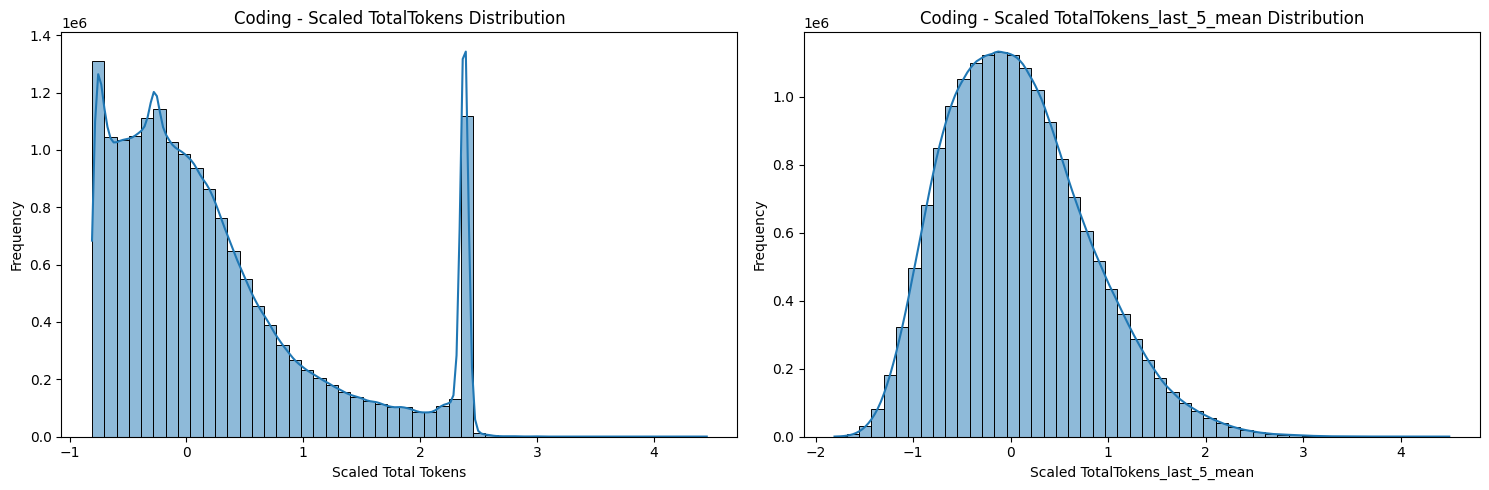

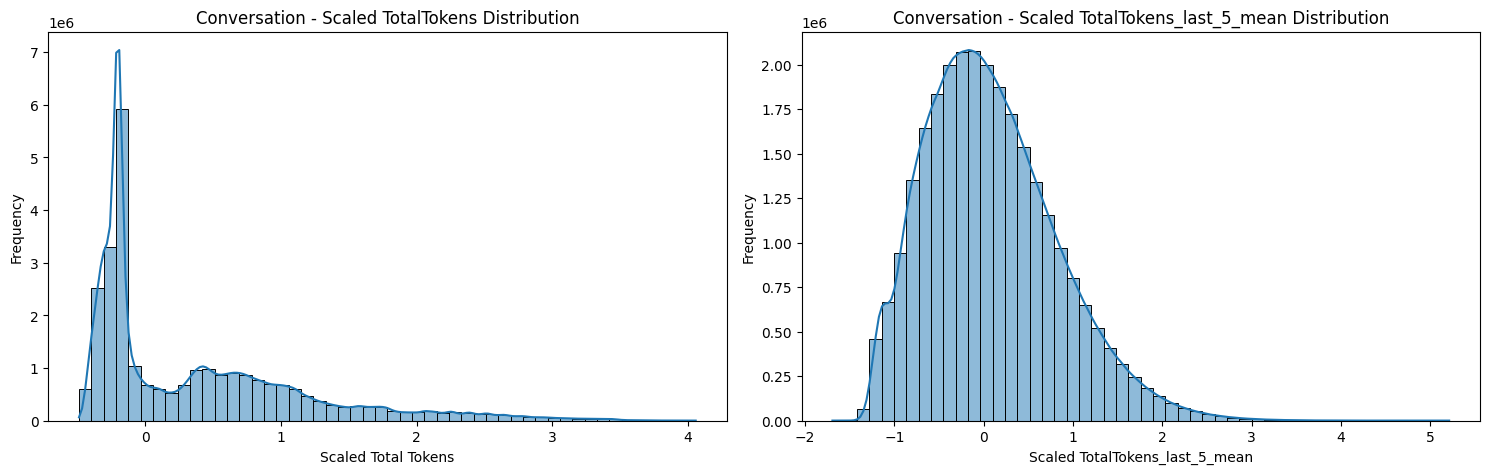

In [10]:
print("\n--- Normalization/Scaling Features ---")

# Define features to be scaled. Exclude TIMESTAMP and the engineered time features (HourOfDay, DayOfWeek etc.)
# as they are cyclic or categorical and don't typically need numerical scaling in the same way.
# Also exclude the original ContextTokens and GeneratedTokens if TotalTokens and rolling/lag features are preferred for models.
features_to_scale = [
    'ContextTokens',
    'GeneratedTokens',
    'TotalTokens',
    'TotalTokens_last_5_mean', 'TotalTokens_last_5_std',
    'TotalTokens_last_10_mean', 'TotalTokens_last_10_std',
    'TotalTokens_last_20_mean', 'TotalTokens_last_20_std',
    'TotalTokens_lag_1', 'ContextTokens_lag_1', 'GeneratedTokens_lag_1'
]

# Initialize scalers
scaler_robust = RobustScaler()
scaler_standard = StandardScaler()

scaled_data_robust = {}
scaled_data_standard = {}

for trace_name, df in df_traces.items():
    print(f"\nScaling features for {trace_name} trace...")

    # Select only the features that exist in the current DataFrame to avoid KeyError
    current_features_to_scale = [f for f in features_to_scale if f in df.columns]

    if not current_features_to_scale:
        print(f"No features found to scale in {trace_name} based on the defined list.")
        continue

    # Apply RobustScaler
    df_scaled_robust = df.copy()
    df_scaled_robust[current_features_to_scale] = scaler_robust.fit_transform(df[current_features_to_scale])
    scaled_data_robust[trace_name] = df_scaled_robust
    print(f"{trace_name} - Robust Scaled Data Head:")
    print(scaled_data_robust[trace_name][current_features_to_scale].head())
    print(f"Mean (Robust Scaler): {scaled_data_robust[trace_name][current_features_to_scale].mean().mean():.4f}")
    print(f"Std Dev (Robust Scaler): {scaled_data_robust[trace_name][current_features_to_scale].std().mean():.4f}")

    # Apply StandardScaler
    df_scaled_standard = df.copy()
    df_scaled_standard[current_features_to_scale] = scaler_standard.fit_transform(df[current_features_to_scale])
    scaled_data_standard[trace_name] = df_scaled_standard
    print(f"\n{trace_name} - Standard Scaled Data Head:")
    print(scaled_data_standard[trace_name][current_features_to_scale].head())
    print(f"Mean (Standard Scaler): {scaled_data_standard[trace_name][current_features_to_scale].mean().mean():.4f}")
    print(f"Std Dev (Standard Scaler): {scaled_data_standard[trace_name][current_features_to_scale].std().mean():.4f}")


# Store the chosen scaled data back into df_traces for consistency for now
# We'll stick with RobustScaler for the token-related features given their distributions.
# Original features like HourOfDay, DayOfWeek etc. remain as they are.
for trace_name in TRACE_NAMES:
    if trace_name in scaled_data_robust:
        # Update the original df_traces with the robust scaled numerical features
        for col in scaled_data_robust[trace_name].columns:
            if col in features_to_scale: # Only update the scaled columns
                df_traces[trace_name][col] = scaled_data_robust[trace_name][col]

print("\n--- Final df_traces with selected scaled features ---")
print("Coding Trace Head (with scaled features):")
print(df_traces["Coding"].head())
print("\nConversation Trace Head (with scaled features):")
print(df_traces["Conversation"].head())

# It's good to verify the distributions again after scaling.
for trace_name, df in df_traces.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['TotalTokens'], bins=50, kde=True)
    plt.title(f'{trace_name} - Scaled TotalTokens Distribution')
    plt.xlabel('Scaled Total Tokens')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df['TotalTokens_last_5_mean'], bins=50, kde=True)
    plt.title(f'{trace_name} - Scaled TotalTokens_last_5_mean Distribution')
    plt.xlabel('Scaled TotalTokens_last_5_mean')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [11]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import collections # For deque for queues

# Re-using df_traces from previous steps (assuming it's in the environment)
# If running this code block independently, you'd need to reload/re-process df_traces
# as done in the previous steps.

class LoadBalancingEnv(gym.Env):
    """
    A custom Reinforcement Learning environment for intelligent load balancing.
    Simulates incoming requests from a trace and multiple servers.
    """
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, trace_data, num_servers=3, server_processing_rate_tps=5000,
                 max_concurrent_requests_per_server=10, reward_weights=None):
        super().__init__()

        self.trace_data = trace_data.copy().sort_values(by='TIMESTAMP').reset_index(drop=True)
        self.num_servers = num_servers
        self.server_processing_rate_tps = server_processing_rate_tps # Tokens Per Second
        self.max_concurrent_requests_per_server = max_concurrent_requests_per_server

        # Default reward weights
        self.reward_weights = reward_weights if reward_weights is not None else {
            'response_time_penalty': -0.01, # Penalty per unit of response time
            'queue_penalty': -0.05,       # Penalty per unit of queue length
            'overload_penalty': -10,      # Large penalty for exceeding max concurrent requests
            'utilization_balance_reward': 0.1, # Reward for balanced utilization (lower std dev)
            'request_completion_reward': 1   # Reward for successfully serving a request
        }

        self.current_step = 0
        self.current_time = pd.Timestamp.min # Will be updated to the first request's timestamp

        # Initialize servers
        self.servers = []
        for i in range(self.num_servers):
            self.servers.append({
                'id': i,
                'active_requests': [], # List of {'request_id', 'total_tokens', 'start_time', 'finish_time'}
                'queue': collections.deque(), # Requests waiting {'request_id', 'total_tokens', 'arrival_time'}
                'current_load_tokens': 0, # Sum of tokens of active requests
                'last_request_finish_time': pd.Timestamp.min, # To manage sequential processing
                'processed_requests_count': 0,
                'total_processed_tokens': 0,
                'response_times': collections.deque(maxlen=100) # Store last 100 response times for avg
            })

        # Define Observation Space (State Space)
        # This needs to be carefully constructed based on the features we engineered and simulated server states.
        # Let's define the ranges for each feature. Using float('-inf') and float('inf') for unconstrained.

        # Request features from scaled data (assuming RobustScaler, so values are roughly around 0)
        # We need to ensure the order of features is consistent with how we concatenate them for the state.
        self.request_features_spec = {
            'TotalTokens': {'low': -10, 'high': 10}, # Example range post-scaling
            'ContextTokens': {'low': -10, 'high': 10},
            'GeneratedTokens': {'low': -10, 'high': 10},
            'HourOfDay': {'low': 0, 'high': 23}, # These are not scaled
            'DayOfWeek': {'low': 0, 'high': 6}, # These are not scaled
            'TotalTokens_last_5_mean': {'low': -10, 'high': 10},
            'TotalTokens_last_5_std': {'low': -10, 'high': 10},
            'TotalTokens_lag_1': {'low': -10, 'high': 10},
            # Add other relevant scaled rolling/lag features
            'ContextTokens_last_5_mean': {'low': -10, 'high': 10},
            'GeneratedTokens_last_5_mean': {'low': -10, 'high': 10},
        }

        # Server features (these will be simulated values)
        self.server_features_spec = {
            'current_load_tokens': {'low': 0, 'high': 100000}, # Max tokens a server can hold at once
            'queue_length': {'low': 0, 'high': 1000}, # Max queue length
            'utilization_ratio': {'low': 0.0, 'high': 1.0}, # 0 to 100%
            'estimated_wait_time': {'low': 0.0, 'high': 300.0}, # Max wait time in seconds (e.g., 5 min)
            'avg_response_time': {'low': 0.0, 'high': 60.0} # Avg response time in seconds (e.g., 1 min)
        }

        # Construct the full observation space
        lows = []
        highs = []
        # Add request feature bounds
        for feature in self.request_features_spec.keys():
            lows.append(self.request_features_spec[feature]['low'])
            highs.append(self.request_features_spec[feature]['high'])

        # Add server feature bounds for each server
        for _ in range(self.num_servers):
            for feature in self.server_features_spec.keys():
                lows.append(self.server_features_spec[feature]['low'])
                highs.append(self.server_features_spec[feature]['high'])

        self.observation_space = spaces.Box(
            low=np.array(lows, dtype=np.float32),
            high=np.array(highs, dtype=np.float32),
            dtype=np.float32
        )

        # Define Action Space (choosing a server)
        self.action_space = spaces.Discrete(self.num_servers)

        self.current_request_idx = 0
        self.done = False

    def _get_obs(self, current_request):
        """
        Constructs the observation (state) for the agent.
        """
        # Request features (assuming the trace data is already preprocessed and scaled)
        request_obs = [
            current_request['TotalTokens'],
            current_request['ContextTokens'],
            current_request['GeneratedTokens'],
            current_request['HourOfDay'],
            current_request['DayOfWeek'],
            current_request['TotalTokens_last_5_mean'],
            current_request['TotalTokens_last_5_std'],
            current_request['TotalTokens_lag_1'],
            current_request['ContextTokens_last_5_mean'],
            current_request['GeneratedTokens_last_5_mean'],
        ]

        # Server features
        server_obs = []
        for server in self.servers:
            # Calculate current utilization ratio (simplified)
            # This is a very rough estimate; actual utilization would involve CPU, memory, etc.
            # Here, we can estimate based on number of active requests vs max concurrent
            active_requests_count = len(server['active_requests'])
            utilization_ratio = active_requests_count / self.max_concurrent_requests_per_server

            # Estimated wait time in queue (very basic: total tokens in queue / processing rate)
            queue_tokens = sum(req['total_tokens'] for req in server['queue'])
            estimated_queue_wait_time = queue_tokens / self.server_processing_rate_tps

            # Average response time for the last 100 requests
            avg_resp_time = np.mean(server['response_times']) if server['response_times'] else 0.0

            server_obs.extend([
                server['current_load_tokens'],
                len(server['queue']),
                utilization_ratio,
                estimated_queue_wait_time,
                avg_resp_time
            ])
        return np.array(request_obs + server_obs, dtype=np.float32)

    def _process_request_on_server(self, server_id, request_data, current_time):
        """
        Simulates processing a single request on a given server.
        Updates server state and returns estimated finish time.
        """
        server = self.servers[server_id]
        total_tokens = request_data['TotalTokens']

        # Calculate estimated processing time
        processing_duration = total_tokens / self.server_processing_rate_tps # in seconds

        # Determine when the request can start processing
        # It starts after current_time AND after any previously enqueued requests on this server
        # and also after existing active requests if server is at max capacity
        start_processing_time = current_time

        # Check for server capacity for active requests
        if len(server['active_requests']) >= self.max_concurrent_requests_per_server:
            # If server is at max capacity, queue the request
            server['queue'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'arrival_time': current_time # This is the time it joined the queue
            })
            # This request will not start processing immediately, so its estimated start time is complex.
            # For simplicity, we'll let `_update_server_states` manage picking from queue.
            # Return a large estimated finish time if queued for immediate reward calculation
            return float('inf'), True # Return True to indicate it was queued

        # If not at max concurrent capacity, or if it's the first request
        # Determine the earliest time this request can finish
        # It must finish after it starts, AND after the server's previous request finishes if sequential.
        # Here we simplify: assume concurrent processing up to max_concurrent_requests_per_server.
        # If there are slots, it can start immediately.

        finish_time = current_time + pd.Timedelta(seconds=processing_duration)

        server['active_requests'].append({
            'request_id': self.current_request_idx,
            'total_tokens': total_tokens,
            'start_time': current_time,
            'finish_time': finish_time
        })
        server['current_load_tokens'] += total_tokens
        return finish_time, False # Return False to indicate it was not queued

    def _update_server_states(self, current_timestamp):
        """
        Updates server states by moving completed requests out of active list
        and potentially moving requests from queue to active.
        """
        for server in self.servers:
            # 1. Remove completed active requests
            completed_requests = []
            for req in server['active_requests']:
                if req['finish_time'] <= current_timestamp:
                    completed_requests.append(req)

            for req in completed_requests:
                server['active_requests'].remove(req)
                server['current_load_tokens'] -= req['total_tokens']
                response_time = (req['finish_time'] - req['start_time']).total_seconds()
                server['response_times'].append(response_time)
                server['processed_requests_count'] += 1
                server['total_processed_tokens'] += req['total_tokens']

            # 2. Move requests from queue to active if capacity is available
            while server['queue'] and len(server['active_requests']) < self.max_concurrent_requests_per_server:
                queued_req = server['queue'].popleft()
                # When a queued request starts, it starts NOW (current_timestamp)
                # Or after the last request finishes on this server, to prevent time travel
                start_time_for_queued = max(current_timestamp, server['last_request_finish_time'])
                processing_duration = queued_req['total_tokens'] / self.server_processing_rate_tps
                finish_time_for_queued = start_time_for_queued + pd.Timedelta(seconds=processing_duration)

                server['active_requests'].append({
                    'request_id': queued_req['request_id'],
                    'total_tokens': queued_req['total_tokens'],
                    'start_time': start_time_for_queued,
                    'finish_time': finish_time_for_queued
                })
                server['current_load_tokens'] += queued_req['total_tokens']
                server['last_request_finish_time'] = finish_time_for_queued # Update last finish time

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.current_request_idx = 0
        self.current_time = self.trace_data['TIMESTAMP'].iloc[0] if not self.trace_data.empty else pd.Timestamp.now(tz='UTC')
        self.done = False

        # Reset all server states
        for server in self.servers:
            server['active_requests'] = []
            server['queue'] = collections.deque()
            server['current_load_tokens'] = 0
            server['last_request_finish_time'] = self.current_time
            server['processed_requests_count'] = 0
            server['total_processed_tokens'] = 0
            server['response_times'] = collections.deque(maxlen=100) # Reset response time history

        # Get the first request from the trace
        if self.trace_data.empty:
            raise ValueError("Trace data is empty. Cannot reset environment.")

        initial_request = self.trace_data.iloc[self.current_request_idx]
        observation = self._get_obs(initial_request)
        info = {} # Can add initial info here if needed
        return observation, info

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode is done. Call reset() to start a new episode.")

        # Get the current request
        current_request = self.trace_data.iloc[self.current_request_idx]
        request_arrival_time = current_request['TIMESTAMP']

        # Ensure environment time advances to the current request's arrival time
        if request_arrival_time > self.current_time:
            self.current_time = request_arrival_time
        # Or, handle time advancement more carefully: first process all requests that finish
        # between the old self.current_time and request_arrival_time.
        self._update_server_states(self.current_time)


        # Assign request to the chosen server
        chosen_server_id = action
        reward = 0
        truncated = False # For Gym API, indicates if episode was truncated (e.g., time limit)

        # Process the request on the chosen server
        # This function returns estimated finish time and whether it was queued
        estimated_finish_time, was_queued = self._process_request_on_server(
            chosen_server_id, current_request, self.current_time
        )

        # --- Reward Calculation ---
        # Initialize reward components
        response_time_reward = 0
        queue_penalty = 0
        overload_penalty = 0
        utilization_balance_reward = 0
        request_completion_reward = 0

        # Penalty for queueing (if applicable) or initial estimated response time
        if was_queued:
            # We penalize queueing heavily
            queue_penalty = self.reward_weights['queue_penalty']
        else:
            # For immediately processed requests, base penalty on estimated processing time
            # For now, let's use the current request's processing time for immediate reward.
            # The actual response time will be known when the request finishes later.
            estimated_processing_time = (current_request['TotalTokens'] / self.server_processing_rate_tps)
            response_time_reward = self.reward_weights['response_time_penalty'] * estimated_processing_time


        # Overload penalty (if server exceeds max concurrent capacity)
        # This is caught by `was_queued` check, but let's add an explicit one if the server is picked when full.
        if len(self.servers[chosen_server_id]['active_requests']) > self.max_concurrent_requests_per_server:
             overload_penalty = self.reward_weights['overload_penalty']

        # Utilization balance reward (calculate across all servers)
        current_server_loads = [s['current_load_tokens'] for s in self.servers]
        # Avoid std dev of zero if all loads are zero or there's only one server
        if len(current_server_loads) > 1 and np.sum(current_server_loads) > 0:
            utilization_balance_reward = self.reward_weights['utilization_balance_reward'] * (1 - np.std(current_server_loads) / np.mean(current_server_loads))
            # Normalize std dev by mean to get a relative measure of imbalance
        elif len(current_server_loads) == 1: # Single server, always balanced
            utilization_balance_reward = self.reward_weights['utilization_balance_reward']
        else: # No load
            utilization_balance_reward = 0


        # Request completion reward (always given if request is processed/queued successfully)
        request_completion_reward = self.reward_weights['request_completion_reward']


        # Sum all reward components
        reward = (response_time_reward + queue_penalty + overload_penalty +
                  utilization_balance_reward + request_completion_reward)


        # Move to the next request
        self.current_request_idx += 1
        if self.current_request_idx >= len(self.trace_data):
            self.done = True # End of episode if all requests processed
            next_observation = self._get_obs(self.trace_data.iloc[-1]) # Return last state
        else:
            next_request = self.trace_data.iloc[self.current_request_idx]
            next_observation = self._get_obs(next_request)

        # Info dictionary (for debugging and additional metrics)
        info = {
            'chosen_server': chosen_server_id,
            'request_id': self.current_request_idx - 1, # ID of the request just processed
            'request_total_tokens': current_request['TotalTokens'],
            'estimated_processing_time': current_request['TotalTokens'] / self.server_processing_rate_tps,
            'was_queued': was_queued,
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens']} for s in self.servers},
            'reward_components': {
                'response_time_reward': response_time_reward,
                'queue_penalty': queue_penalty,
                'overload_penalty': overload_penalty,
                'utilization_balance_reward': utilization_balance_reward,
                'request_completion_reward': request_completion_reward
            }
        }

        return next_observation, reward, self.done, truncated, info

    def render(self):
        # Optional: Implement rendering if you want to visualize the simulation (e.g., using matplotlib)
        # For now, we'll leave this as a placeholder.
        pass

    def close(self):
        # Clean up resources if necessary
        pass

In [12]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import collections # For deque for queues

# Ensure df_traces is available from previous steps. If running this cell alone,
# you would need to re-run the data loading and feature engineering steps.

# Define a subset of the trace data for quick testing, otherwise it will run for too long.
# Let's take the first 1000 requests from the Coding trace.
test_trace_data = df_traces["Coding"].head(1000).copy()

print("\n--- Testing the LoadBalancingEnv ---")

# Environment Parameters
NUM_SERVERS = 3
SERVER_PROCESSING_RATE_TPS = 5000 # Tokens per second
MAX_CONCURRENT_REQUESTS_PER_SERVER = 5 # Small number for easier observation

try:
    env = LoadBalancingEnv(
        trace_data=test_trace_data,
        num_servers=NUM_SERVERS,
        server_processing_rate_tps=SERVER_PROCESSING_RATE_TPS,
        max_concurrent_requests_per_server=MAX_CONCURRENT_REQUESTS_PER_SERVER
    )

    observation, info = env.reset()
    print(f"\nInitial Observation Shape: {observation.shape}")
    print(f"Initial Observation (first few elements): {observation[:5]}") # Display first few elements
    print(f"Initial Server States: {info.get('server_states', 'N/A')}")


    num_simulation_steps = 20 # Run for 20 steps (requests)

    total_rewards = 0
    print(f"\nRunning simulation for {num_simulation_steps} steps...")
    for i in range(num_simulation_steps):
        # Agent chooses a random action (server) for demonstration
        action = env.action_space.sample() # Randomly choose a server

        next_observation, reward, done, truncated, info = env.step(action)

        total_rewards += reward

        print(f"\n--- Step {i+1} ---")
        print(f"Request TIMESTAMP: {test_trace_data.iloc[env.current_request_idx - 1]['TIMESTAMP']}")
        print(f"Action taken (server chosen): {action}")
        print(f"Reward: {reward:.4f}")
        print(f"Reward Components: {info['reward_components']}")
        print(f"Server States after action: {info['server_states']}")
        print(f"Next Observation (first few elements): {next_observation[:5]}")

        if done:
            print("\nEpisode finished.")
            break

    print(f"\nTotal Reward over {i+1} steps: {total_rewards:.4f}")

except Exception as e:
    print(f"\nAn error occurred during environment testing: {e}")

finally:
    env.close() # Ensure environment resources are properly closed


--- Testing the LoadBalancingEnv ---

Initial Observation Shape: (25,)
Initial Observation (first few elements): [ 0.08913764  0.09626556 -0.2         0.          4.        ]
Initial Server States: N/A

Running simulation for 20 steps...

--- Step 1 ---
Request TIMESTAMP: 2024-05-10 00:00:00.009930+00:00
Action taken (server chosen): 0
Reward: 0.9586
Reward Components: {'response_time_reward': np.float64(-1.7827529021558872e-07), 'queue_penalty': 0, 'overload_penalty': 0, 'utilization_balance_reward': np.float64(-0.04142135623730952), 'request_completion_reward': 1}
Server States after action: {0: {'active_requests': 1, 'queue_length': 0, 'current_load_tokens': np.float64(0.08913764510779436)}, 1: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens': 0}, 2: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens': 0}}
Next Observation (first few elements): [ 0.18781094  0.19460581 -0.13333334  0.          4.        ]

--- Step 2 ---
Request TIMESTAMP: 2024-05-10 00:0

Revised LoadBalancingEnv (with minor fixes and clarifications)

In [13]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import collections # For deque for queues

class LoadBalancingEnv(gym.Env):
    """
    A custom Reinforcement Learning environment for intelligent load balancing.
    Simulates incoming requests from a trace and multiple servers.
    """
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, trace_data, num_servers=3, server_processing_rate_tps=5000,
                 max_concurrent_requests_per_server=5, reward_weights=None,
                 response_time_history_len=100):
        super().__init__()

        # Ensure trace_data is sorted by TIMESTAMP and has necessary features
        self.trace_data = trace_data.copy().sort_values(by='TIMESTAMP').reset_index(drop=True)
        if self.trace_data.empty:
            raise ValueError("Provided trace data is empty.")

        self.num_servers = num_servers
        self.server_processing_rate_tps = server_processing_rate_tps # Tokens Per Second
        self.max_concurrent_requests_per_server = max_concurrent_requests_per_server
        self.response_time_history_len = response_time_history_len # Length for moving average of response times

        # Default reward weights (can be tuned)
        self.reward_weights = reward_weights if reward_weights is not None else {
            'response_time_penalty_per_sec': -0.01, # Penalty per second of estimated processing time
            'queue_penalty_per_item': -0.1,     # Penalty per item in queue
            'overload_penalty': -10,            # Large penalty for selecting an already max-capacity server
            'utilization_balance_reward_factor': 0.1, # Factor for rewarding balanced utilization
            'request_completion_reward': 1      # Base reward for successfully handling (queuing/processing) a request
        }

        self.current_step = 0
        self.current_time = pd.Timestamp.min # Placeholder, set in reset()

        # Initialize servers
        self.servers = []
        for i in range(self.num_servers):
            self.servers.append({
                'id': i,
                'active_requests': [], # List of {'request_id', 'total_tokens', 'start_time', 'finish_time'}
                'queue': collections.deque(), # Requests waiting {'request_id', 'total_tokens', 'arrival_time'}
                'current_load_tokens': 0, # Sum of tokens of active requests
                'last_request_finish_time': self.current_time, # Tracks when the last request on this server finished/is expected to finish
                'processed_requests_count': 0,
                'total_processed_tokens': 0,
                'response_times': collections.deque(maxlen=self.response_time_history_len) # Store last N response times
            })

        # Define Observation Space (State Space)
        # This needs to be carefully constructed based on the features we engineered and simulated server states.
        # Ensure the order of features is consistent in _get_obs
        self.request_features_spec = {
            'TotalTokens': {'low': -10, 'high': 10},
            'ContextTokens': {'low': -10, 'high': 10},
            'GeneratedTokens': {'low': -10, 'high': 10},
            'HourOfDay': {'low': 0, 'high': 23},
            'DayOfWeek': {'low': 0, 'high': 6},
            'TotalTokens_last_5_mean': {'low': -10, 'high': 10},
            'TotalTokens_last_5_std': {'low': -10, 'high': 10},
            'TotalTokens_lag_1': {'low': -10, 'high': 10},
            'ContextTokens_last_5_mean': {'low': -10, 'high': 10},
            'GeneratedTokens_last_5_mean': {'low': -10, 'high': 10},
        }

        self.server_features_spec = {
            'current_load_tokens': {'low': 0, 'high': float('inf')}, # Load can grow very large in queue
            'queue_length': {'low': 0, 'high': float('inf')}, # Queue length can be large
            'utilization_ratio': {'low': 0.0, 'high': 1.0}, # Active requests / max concurrent
            'estimated_queue_wait_time': {'low': 0.0, 'high': float('inf')}, # Sum of processing times in queue
            'avg_response_time': {'low': 0.0, 'high': float('inf')} # Average response time for last N requests
        }

        lows = []
        highs = []
        for feature in self.request_features_spec.keys():
            lows.append(self.request_features_spec[feature]['low'])
            highs.append(self.request_features_spec[feature]['high'])

        for _ in range(self.num_servers):
            for feature in self.server_features_spec.keys():
                lows.append(self.server_features_spec[feature]['low'])
                highs.append(self.server_features_spec[feature]['high'])

        self.observation_space = spaces.Box(
            low=np.array(lows, dtype=np.float32),
            high=np.array(highs, dtype=np.float32),
            dtype=np.float32
        )

        self.action_space = spaces.Discrete(self.num_servers)

        self.current_request_idx = 0
        self.done = False

    def _get_obs(self, current_request):
        """
        Constructs the observation (state) for the agent.
        Features must be in the same order as defined in observation_space bounds.
        """
        request_obs = [
            current_request['TotalTokens'],
            current_request['ContextTokens'],
            current_request['GeneratedTokens'],
            current_request['HourOfDay'],
            current_request['DayOfWeek'],
            current_request['TotalTokens_last_5_mean'],
            current_request['TotalTokens_last_5_std'],
            current_request['TotalTokens_lag_1'],
            current_request['ContextTokens_last_5_mean'],
            current_request['GeneratedTokens_last_5_mean'],
        ]

        server_obs = []
        for server in self.servers:
            active_requests_count = len(server['active_requests'])
            utilization_ratio = active_requests_count / self.max_concurrent_requests_per_server

            # Estimated queue wait time: sum of processing times of requests currently in queue
            estimated_queue_wait_time = sum(req['total_tokens'] for req in server['queue']) / self.server_processing_rate_tps

            avg_resp_time = np.mean(server['response_times']) if server['response_times'] else 0.0

            server_obs.extend([
                server['current_load_tokens'],
                len(server['queue']),
                utilization_ratio,
                estimated_queue_wait_time,
                avg_resp_time
            ])
        return np.array(request_obs + server_obs, dtype=np.float32)

    def _process_request_on_server(self, server_id, request_data, arrival_time):
        """
        Simulates assigning a request to a server.
        Returns whether it was queued and its immediate processing cost.
        """
        server = self.servers[server_id]
        total_tokens = request_data['TotalTokens']
        estimated_processing_duration = total_tokens / self.server_processing_rate_tps # in seconds

        was_queued = False
        start_processing_time = arrival_time
        finish_processing_time = arrival_time + pd.Timedelta(seconds=estimated_processing_duration) # Default, assumes immediate start

        # Check if server is at max concurrent capacity
        if len(server['active_requests']) >= self.max_concurrent_requests_per_server:
            # If at max capacity, add to queue
            server['queue'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'arrival_time': arrival_time, # Time it entered the queue
                'estimated_processing_duration': estimated_processing_duration
            })
            was_queued = True
            # For immediate reward, consider the current estimated wait time in queue if queued
            immediate_processing_cost_for_reward = estimated_processing_duration + \
                                                  sum(req['estimated_processing_duration'] for req in server['queue']) # sum of queued items
        else:
            # If capacity is available, add to active requests
            server['active_requests'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'start_time': start_processing_time,
                'finish_time': finish_processing_time
            })
            server['current_load_tokens'] += total_tokens
            immediate_processing_cost_for_reward = estimated_processing_duration

        return was_queued, immediate_processing_cost_for_reward


    def _update_server_states(self, current_timestamp):
        """
        Updates server states by moving completed requests out of active list
        and potentially moving requests from queue to active.
        """
        for server in self.servers:
            # 1. Remove completed active requests
            completed_requests = []
            for req in server['active_requests']:
                if req['finish_time'] <= current_timestamp:
                    completed_requests.append(req)

            for req in completed_requests:
                server['active_requests'].remove(req)
                server['current_load_tokens'] -= req['total_tokens']
                # Record actual response time
                response_time = (req['finish_time'] - req['start_time']).total_seconds()
                server['response_times'].append(response_time)
                server['processed_requests_count'] += 1
                server['total_processed_tokens'] += req['total_tokens']

            # 2. Move requests from queue to active if capacity is available
            # Requests start processing after all currently active requests *that started before them* finish.
            # Here, we simplify: a queued request starts as soon as a slot opens and its turn comes.
            while server['queue'] and len(server['active_requests']) < self.max_concurrent_requests_per_server:
                queued_req = server['queue'].popleft() # Get the oldest queued request

                # The start time for a queued request is the maximum of:
                # 1. The current simulation time (current_timestamp)
                # 2. The estimated finish time of the last request that was *already committed* to this server
                start_time_for_queued = max(current_timestamp, server['last_request_finish_time'])

                processing_duration = queued_req['total_tokens'] / self.server_processing_rate_tps
                finish_time_for_queued = start_time_for_queued + pd.Timedelta(seconds=processing_duration)

                server['active_requests'].append({
                    'request_id': queued_req['request_id'],
                    'total_tokens': queued_req['total_tokens'],
                    'start_time': start_time_for_queued,
                    'finish_time': finish_time_for_queued
                })
                server['current_load_tokens'] += queued_req['total_tokens']
                server['last_request_finish_time'] = finish_time_for_queued # Update this server's "busyness" mark

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.current_request_idx = 0
        # Initialize current_time to the timestamp of the first request
        self.current_time = self.trace_data['TIMESTAMP'].iloc[0]

        self.done = False

        # Reset all server states
        for server in self.servers:
            server['active_requests'] = []
            server['queue'] = collections.deque()
            server['current_load_tokens'] = 0
            server['last_request_finish_time'] = self.current_time # All servers available at episode start
            server['processed_requests_count'] = 0
            server['total_processed_tokens'] = 0
            server['response_times'] = collections.deque(maxlen=self.response_time_history_len)

        # Get the first request from the trace
        initial_request = self.trace_data.iloc[self.current_request_idx]
        observation = self._get_obs(initial_request)
        
        # Initial info (server states will be empty/reset)
        info = {
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens']} for s in self.servers}
        }
        return observation, info

    def step(self, action):
        if self.done:
            # If the episode is done, calling step should raise an error or return a zero reward
            # This is standard gym behavior.
            print("Warning: Calling step() on a finished episode. Reset the environment.")
            return np.zeros_like(self.observation_space.low), 0.0, True, False, {}

        # Get the current request
        current_request = self.trace_data.iloc[self.current_request_idx]
        request_arrival_time = current_request['TIMESTAMP']

        # Advance simulation time to the current request's arrival time, processing any requests
        # that finished in the interim.
        self.current_time = request_arrival_time
        self._update_server_states(self.current_time) # Clear completed requests and fill from queue

        # Assign request to the chosen server
        chosen_server_id = action
        reward = 0
        truncated = False # Not using truncation (e.g., time limits) for now

        # Before processing, check if the chosen server is already at max capacity for overload penalty
        # This penalizes the *decision* to pick a full server.
        server_at_capacity_before_decision = (len(self.servers[chosen_server_id]['active_requests']) >= self.max_concurrent_requests_per_server)

        # Process the request on the chosen server
        # This function returns whether it was queued and the immediate processing cost for reward
        was_queued, immediate_processing_cost_for_reward = self._process_request_on_server(
            chosen_server_id, current_request, self.current_time
        )

        # --- Reward Calculation ---
        response_time_reward = self.reward_weights['response_time_penalty_per_sec'] * immediate_processing_cost_for_reward
        queue_penalty = self.reward_weights['queue_penalty_per_item'] * len(self.servers[chosen_server_id]['queue'])
        overload_penalty = self.reward_weights['overload_penalty'] if server_at_capacity_before_decision else 0

        # Utilization balance reward (calculate across all servers)
        current_server_loads = [s['current_load_tokens'] for s in self.servers]
        if len(current_server_loads) > 1 and np.sum(current_server_loads) > 0:
            # We want to minimize standard deviation. So, 1 - (normalized std dev)
            # A higher std dev means less balanced, so less reward.
            # Normalize std dev by mean to make it relative. Avoid division by zero if mean is zero.
            mean_load = np.mean(current_server_loads)
            std_load = np.std(current_server_loads)
            if mean_load > 0:
                # Closer to 1 is better (low std dev), closer to 0 is worse (high std dev)
                balance_metric = 1 - (std_load / mean_load)
            else: # All servers have 0 load, considered perfectly balanced
                balance_metric = 1
            utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor'] * balance_metric
        elif len(current_server_loads) == 1: # Single server, always balanced
            utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor'] # Full reward for balance
        else: # No servers or no load, should not happen with current setup
            utilization_balance_reward = 0

        request_completion_reward = self.reward_weights['request_completion_reward']

        reward = (response_time_reward + queue_penalty + overload_penalty +
                  utilization_balance_reward + request_completion_reward)


        # Move to the next request
        self.current_request_idx += 1
        if self.current_request_idx >= len(self.trace_data):
            self.done = True
            # For the final step, observation might be from the last state before done.
            # Or pass zeros. Gym recommends returning the last valid observation.
            next_observation = self._get_obs(self.trace_data.iloc[-1])
        else:
            next_request = self.trace_data.iloc[self.current_request_idx]
            next_observation = self._get_obs(next_request)

        info = {
            'chosen_server': chosen_server_id,
            'request_id': self.current_request_idx - 1,
            'request_total_tokens': current_request['TotalTokens'],
            'estimated_processing_time_of_this_request': current_request['TotalTokens'] / self.server_processing_rate_tps,
            'was_queued': was_queued,
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens'], 'avg_response_time': np.mean(s['response_times']) if s['response_times'] else 0} for s in self.servers},
            'reward_components': {
                'response_time_penalty_per_sec': response_time_reward,
                'queue_penalty_per_item': queue_penalty,
                'overload_penalty': overload_penalty,
                'utilization_balance_reward': utilization_balance_reward,
                'request_completion_reward': request_completion_reward
            }
        }

        return next_observation, reward, self.done, truncated, info

    def render(self):
        pass

    def close(self):
        pass

In [14]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import collections # For deque for queues

# Ensure df_traces is available from previous steps. If running this cell alone,
# you would need to re-run the data loading and feature engineering steps.

# Define a subset of the trace data for quick testing, otherwise it will run for too long.
# Let's take the first 1000 requests from the Coding trace.
test_trace_data = df_traces["Coding"].head(1000).copy()

print("\n--- Testing the LoadBalancingEnv ---")

# Environment Parameters
NUM_SERVERS = 3
SERVER_PROCESSING_RATE_TPS = 5000 # Tokens per second
MAX_CONCURRENT_REQUESTS_PER_SERVER = 5 # Small number for easier observation

try:
    env = LoadBalancingEnv(
        trace_data=test_trace_data,
        num_servers=NUM_SERVERS,
        server_processing_rate_tps=SERVER_PROCESSING_RATE_TPS,
        max_concurrent_requests_per_server=MAX_CONCURRENT_REQUESTS_PER_SERVER
    )

    observation, info = env.reset()
    print(f"\nInitial Observation Shape: {observation.shape}")
    print(f"Initial Observation (first few elements): {observation[:5]}") # Display first few elements
    print(f"Initial Server States: {info.get('server_states', 'N/A')}")


    num_simulation_steps = 20 # Run for 20 steps (requests)

    total_rewards = 0
    print(f"\nRunning simulation for {num_simulation_steps} steps...")
    for i in range(num_simulation_steps):
        # Agent chooses a random action (server) for demonstration
        action = env.action_space.sample() # Randomly choose a server

        next_observation, reward, done, truncated, info = env.step(action)

        total_rewards += reward

        print(f"\n--- Step {i+1} ---")
        print(f"Request TIMESTAMP: {test_trace_data.iloc[env.current_request_idx - 1]['TIMESTAMP']}")
        print(f"Action taken (server chosen): {action}")
        print(f"Reward: {reward:.4f}")
        print(f"Reward Components: {info['reward_components']}")
        print(f"Server States after action: {info['server_states']}")
        print(f"Next Observation (first few elements): {next_observation[:5]}")

        if done:
            print("\nEpisode finished.")
            break

    print(f"\nTotal Reward over {i+1} steps: {total_rewards:.4f}")

except Exception as e:
    print(f"\nAn error occurred during environment testing: {e}")

finally:
    env.close() # Ensure environment resources are properly closed


--- Testing the LoadBalancingEnv ---

Initial Observation Shape: (25,)
Initial Observation (first few elements): [ 0.08913764  0.09626556 -0.2         0.          4.        ]
Initial Server States: {0: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens': 0}, 1: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens': 0}, 2: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens': 0}}

Running simulation for 20 steps...

--- Step 1 ---
Request TIMESTAMP: 2024-05-10 00:00:00.009930+00:00
Action taken (server chosen): 2
Reward: 0.9586
Reward Components: {'response_time_penalty_per_sec': np.float64(-1.7827529021558872e-07), 'queue_penalty_per_item': -0.0, 'overload_penalty': 0, 'utilization_balance_reward': np.float64(-0.04142135623730952), 'request_completion_reward': 1}
Server States after action: {0: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens': 0, 'avg_response_time': 0}, 1: {'active_requests': 0, 'queue_length': 0, 'current_load_tokens':

10. Training an RL Agent with Stable Baselines3 (PPO)

In [ ]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import collections
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
import os

# Ensure df_traces is available from previous steps.
# If running this cell alone, you would need to re-run the data loading and feature engineering steps.
# For demonstration, let's load a subset of the data if not already loaded.
# (This block is for standalone execution of this section, assuming df_traces might not persist)
try:
    if 'df_traces' not in locals():
        print("df_traces not found, loading data...")
        TRACE_NAMES = [
            "Coding",
            "Conversation",
        ]
        TRACE_FILENAMES = [
            "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_code_1week.csv",
            "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_conv_1week.csv",
        ]
        df_traces = {}
        for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
            df = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"], date_format="mixed", dayfirst=False)
            df = df.sort_values(by='TIMESTAMP').reset_index(drop=True)
            df['HourOfDay'] = df['TIMESTAMP'].dt.hour
            df['DayOfWeek'] = df['TIMESTAMP'].dt.dayofweek
            df['DayOfMonth'] = df['TIMESTAMP'].dt.day
            df['WeekOfYear'] = df['TIMESTAMP'].dt.isocalendar().week.astype(int)
            df['TotalTokens'] = df['ContextTokens'] + df['GeneratedTokens']

            # Advanced features (re-copied from previous step to ensure standalone execution)
            rolling_counts = [5, 10, 20]
            df_temp = df.set_index('TIMESTAMP')
            for count in rolling_counts:
                df_temp[f'TotalTokens_last_{count}_mean'] = df_temp['TotalTokens'].rolling(window=count).mean().fillna(0)
                df_temp[f'TotalTokens_last_{count}_std'] = df_temp['TotalTokens'].rolling(window=count).std().fillna(0)
                df_temp[f'ContextTokens_last_{count}_mean'] = df_temp['ContextTokens'].rolling(window=count).mean().fillna(0)
                df_temp[f'GeneratedTokens_last_{count}_mean'] = df_temp['GeneratedTokens'].rolling(window=count).mean().fillna(0)
            df_temp['TotalTokens_lag_1'] = df_temp['TotalTokens'].shift(1).fillna(0)
            df_temp['ContextTokens_lag_1'] = df_temp['ContextTokens'].shift(1).fillna(0)
            df_temp['GeneratedTokens_lag_1'] = df_temp['GeneratedTokens'].shift(1).fillna(0)
            df_traces[trace_name] = df_temp.reset_index()

            # Scaling (re-copied from previous step)
            features_to_scale = [
                'ContextTokens', 'GeneratedTokens', 'TotalTokens',
                'TotalTokens_last_5_mean', 'TotalTokens_last_5_std',
                'TotalTokens_last_10_mean', 'TotalTokens_last_10_std',
                'TotalTokens_last_20_mean', 'TotalTokens_last_20_std',
                'TotalTokens_lag_1', 'ContextTokens_lag_1', 'GeneratedTokens_lag_1'
            ]
            scaler_robust = RobustScaler()
            current_features_to_scale = [f for f in features_to_scale if f in df_traces[trace_name].columns]
            if current_features_to_scale:
                df_traces[trace_name][current_features_to_scale] = scaler_robust.fit_transform(df_traces[trace_name][current_features_to_scale])
except NameError:
    print("df_traces variable not found, proceeding with the assumption it will be loaded from previous steps.")


# --- Define the LoadBalancingEnv class again to ensure it's available ---
# (Re-pasting the refined class definition here for standalone execution)
class LoadBalancingEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, trace_data, num_servers=3, server_processing_rate_tps=5000,
                 max_concurrent_requests_per_server=5, reward_weights=None,
                 response_time_history_len=100):
        super().__init__()

        self.trace_data = trace_data.copy().sort_values(by='TIMESTAMP').reset_index(drop=True)
        if self.trace_data.empty:
            raise ValueError("Provided trace data is empty.")

        self.num_servers = num_servers
        self.server_processing_rate_tps = server_processing_rate_tps
        self.max_concurrent_requests_per_server = max_concurrent_requests_per_server
        self.response_time_history_len = response_time_history_len

        self.reward_weights = reward_weights if reward_weights is not None else {
            'response_time_penalty_per_sec': -0.01,
            'queue_penalty_per_item': -0.1,
            'overload_penalty': -10,
            'utilization_balance_reward_factor': 0.1,
            'request_completion_reward': 1
        }

        self.current_step = 0
        self.current_time = pd.Timestamp.min

        self.servers = []
        for i in range(self.num_servers):
            self.servers.append({
                'id': i,
                'active_requests': [],
                'queue': collections.deque(),
                'current_load_tokens': 0,
                'last_request_finish_time': self.current_time,
                'processed_requests_count': 0,
                'total_processed_tokens': 0,
                'response_times': collections.deque(maxlen=self.response_time_history_len)
            })

        self.request_features_spec = {
            'TotalTokens': {'low': -10, 'high': 10},
            'ContextTokens': {'low': -10, 'high': 10},
            'GeneratedTokens': {'low': -10, 'high': 10},
            'HourOfDay': {'low': 0, 'high': 23},
            'DayOfWeek': {'low': 0, 'high': 6},
            'TotalTokens_last_5_mean': {'low': -10, 'high': 10},
            'TotalTokens_last_5_std': {'low': -10, 'high': 10},
            'TotalTokens_lag_1': {'low': -10, 'high': 10},
            'ContextTokens_last_5_mean': {'low': -10, 'high': 10},
            'GeneratedTokens_last_5_mean': {'low': -10, 'high': 10},
        }

        self.server_features_spec = {
            'current_load_tokens': {'low': 0, 'high': float('inf')},
            'queue_length': {'low': 0, 'high': float('inf')},
            'utilization_ratio': {'low': 0.0, 'high': 1.0},
            'estimated_queue_wait_time': {'low': 0.0, 'high': float('inf')},
            'avg_response_time': {'low': 0.0, 'high': float('inf')}
        }

        lows = []
        highs = []
        for feature in self.request_features_spec.keys():
            lows.append(self.request_features_spec[feature]['low'])
            highs.append(self.request_features_spec[feature]['high'])

        for _ in range(self.num_servers):
            for feature in self.server_features_spec.keys():
                lows.append(self.server_features_spec[feature]['low'])
                highs.append(self.server_features_spec[feature]['high'])

        self.observation_space = spaces.Box(
            low=np.array(lows, dtype=np.float32),
            high=np.array(highs, dtype=np.float32),
            dtype=np.float32
        )

        self.action_space = spaces.Discrete(self.num_servers)

        self.current_request_idx = 0
        self.done = False

    def _get_obs(self, current_request):
        request_obs = [
            current_request['TotalTokens'],
            current_request['ContextTokens'],
            current_request['GeneratedTokens'],
            current_request['HourOfDay'],
            current_request['DayOfWeek'],
            current_request['TotalTokens_last_5_mean'],
            current_request['TotalTokens_last_5_std'],
            current_request['TotalTokens_lag_1'],
            current_request['ContextTokens_last_5_mean'],
            current_request['GeneratedTokens_last_5_mean'],
        ]

        server_obs = []
        for server in self.servers:
            active_requests_count = len(server['active_requests'])
            utilization_ratio = active_requests_count / self.max_concurrent_requests_per_server

            estimated_queue_wait_time = sum(req['total_tokens'] for req in server['queue']) / self.server_processing_rate_tps

            avg_resp_time = np.mean(server['response_times']) if server['response_times'] else 0.0

            server_obs.extend([
                server['current_load_tokens'],
                len(server['queue']),
                utilization_ratio,
                estimated_queue_wait_time,
                avg_resp_time
            ])
        return np.array(request_obs + server_obs, dtype=np.float32)

    def _process_request_on_server(self, server_id, request_data, arrival_time):
        server = self.servers[server_id]
        total_tokens = request_data['TotalTokens']
        estimated_processing_duration = total_tokens / self.server_processing_rate_tps

        was_queued = False
        start_processing_time = arrival_time
        finish_processing_time = arrival_time + pd.Timedelta(seconds=estimated_processing_duration)

        if len(server['active_requests']) >= self.max_concurrent_requests_per_server:
            server['queue'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'arrival_time': arrival_time,
                'estimated_processing_duration': estimated_processing_duration
            })
            was_queued = True
            immediate_processing_cost_for_reward = estimated_processing_duration + \
                                                  sum(req['estimated_processing_duration'] for req in server['queue'])
        else:
            server['active_requests'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'start_time': start_processing_time,
                'finish_time': finish_processing_time
            })
            server['current_load_tokens'] += total_tokens
            immediate_processing_cost_for_reward = estimated_processing_duration

        return was_queued, immediate_processing_cost_for_reward


    def _update_server_states(self, current_timestamp):
        for server in self.servers:
            completed_requests = []
            for req in server['active_requests']:
                if req['finish_time'] <= current_timestamp:
                    completed_requests.append(req)

            for req in completed_requests:
                server['active_requests'].remove(req)
                server['current_load_tokens'] -= req['total_tokens']
                response_time = (req['finish_time'] - req['start_time']).total_seconds()
                server['response_times'].append(response_time)
                server['processed_requests_count'] += 1
                server['total_processed_tokens'] += req['total_tokens']

            while server['queue'] and len(server['active_requests']) < self.max_concurrent_requests_per_server:
                queued_req = server['queue'].popleft()

                start_time_for_queued = max(current_timestamp, server['last_request_finish_time'])

                processing_duration = queued_req['total_tokens'] / self.server_processing_rate_tps
                finish_time_for_queued = start_time_for_queued + pd.Timedelta(seconds=processing_duration)

                server['active_requests'].append({
                    'request_id': queued_req['request_id'],
                    'total_tokens': queued_req['total_tokens'],
                    'start_time': start_time_for_queued,
                    'finish_time': finish_time_for_queued
                })
                server['current_load_tokens'] += queued_req['total_tokens']
                server['last_request_finish_time'] = finish_time_for_queued

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.current_request_idx = 0
        self.current_time = self.trace_data['TIMESTAMP'].iloc[0]

        self.done = False

        for server in self.servers:
            server['active_requests'] = []
            server['queue'] = collections.deque()
            server['current_load_tokens'] = 0
            server['last_request_finish_time'] = self.current_time
            server['processed_requests_count'] = 0
            server['total_processed_tokens'] = 0
            server['response_times'] = collections.deque(maxlen=self.response_time_history_len)

        initial_request = self.trace_data.iloc[self.current_request_idx]
        observation = self._get_obs(initial_request)
        
        info = {
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens']} for s in self.servers}
        }
        return observation, info

    def step(self, action):
        if self.done:
            print("Warning: Calling step() on a finished episode. Reset the environment.")
            return np.zeros_like(self.observation_space.low), 0.0, True, False, {}

        current_request = self.trace_data.iloc[self.current_request_idx]
        request_arrival_time = current_request['TIMESTAMP']

        self.current_time = request_arrival_time
        self._update_server_states(self.current_time)

        chosen_server_id = action
        reward = 0
        truncated = False

        server_at_capacity_before_decision = (len(self.servers[chosen_server_id]['active_requests']) >= self.max_concurrent_requests_per_server)

        was_queued, immediate_processing_cost_for_reward = self._process_request_on_server(
            chosen_server_id, current_request, self.current_time
        )

        response_time_reward = self.reward_weights['response_time_penalty_per_sec'] * immediate_processing_cost_for_reward
        queue_penalty = self.reward_weights['queue_penalty_per_item'] * len(self.servers[chosen_server_id]['queue'])
        overload_penalty = self.reward_weights['overload_penalty'] if server_at_capacity_before_decision else 0

        current_server_loads = [s['current_load_tokens'] for s in self.servers]
        if len(current_server_loads) > 1 and np.sum(current_server_loads) > 0:
            mean_load = np.mean(current_server_loads)
            std_load = np.std(current_server_loads)
            if mean_load > 0:
                balance_metric = 1 - (std_load / mean_load)
            else:
                balance_metric = 1
            utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor'] * balance_metric
        elif len(current_server_loads) == 1:
            utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor']
        else:
            utilization_balance_reward = 0

        request_completion_reward = self.reward_weights['request_completion_reward']

        reward = (response_time_reward + queue_penalty + overload_penalty +
                  utilization_balance_reward + request_completion_reward)


        self.current_request_idx += 1
        if self.current_request_idx >= len(self.trace_data):
            self.done = True
            next_observation = self._get_obs(self.trace_data.iloc[-1])
        else:
            next_request = self.trace_data.iloc[self.current_request_idx]
            next_observation = self._get_obs(next_request)

        info = {
            'chosen_server': chosen_server_id,
            'request_id': self.current_request_idx - 1,
            'request_total_tokens': current_request['TotalTokens'],
            'estimated_processing_time_of_this_request': current_request['TotalTokens'] / self.server_processing_rate_tps,
            'was_queued': was_queued,
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens'], 'avg_response_time': np.mean(s['response_times']) if s['response_times'] else 0} for s in self.servers},
            'reward_components': {
                'response_time_penalty_per_sec': response_time_reward,
                'queue_penalty_per_item': queue_penalty,
                'overload_penalty': overload_penalty,
                'utilization_balance_reward': utilization_balance_reward,
                'request_completion_reward': request_completion_reward
            }
        }

        return next_observation, reward, self.done, truncated, info

    def render(self):
        pass

    def close(self):
        pass


# --- Training Configuration ---
LOG_DIR = "./ppo_load_balancer_logs/"
os.makedirs(LOG_DIR, exist_ok=True)

# Use a smaller subset of data for training to start, as a full week is very long.
# For serious training, consider training on a larger subset or multiple episodes.
# Let's use the first 10,000 requests from the "Coding" trace for training.
# A separate, unseen portion for evaluation.
train_data_size = 10000
eval_data_size = 2000

train_trace_data = df_traces["Coding"].iloc[:train_data_size].copy()
eval_trace_data = df_traces["Coding"].iloc[train_data_size:train_data_size + eval_data_size].copy()

# Ensure that eval_trace_data is not empty
if eval_trace_data.empty:
    print("Warning: Evaluation data is empty. Adjust train_data_size or total data size.")
    # Fallback: if no distinct eval data, use a small part of train data for eval.
    # Not ideal but prevents error during initial setup.
    eval_trace_data = df_traces["Coding"].iloc[-1000:].copy() # Last 1000 requests if possible

# Create the training environment
# Stable Baselines3 recommends using VecEnvs for performance
# DummyVecEnv creates a vectorized environment that runs sequentially in a single process.
# This is fine for initial testing; SubprocVecEnv is for parallel execution.
train_env = make_vec_env(
    LoadBalancingEnv,
    env_kwargs={
        'trace_data': train_trace_data,
        'num_servers': 3,
        'server_processing_rate_tps': 5000,
        'max_concurrent_requests_per_server': 5
    },
    n_envs=1, # Number of parallel environments
    seed=0
)

# Create the evaluation environment
eval_env = make_vec_env(
    LoadBalancingEnv,
    env_kwargs={
        'trace_data': eval_trace_data,
        'num_servers': 3,
        'server_processing_rate_tps': 5000,
        'max_concurrent_requests_per_server': 5
    },
    n_envs=1,
    seed=1 # Different seed for evaluation
)


# Define callbacks for evaluation and early stopping
# EvalCallback will evaluate the model periodically and save the best one
# StopTrainingOnNoModelImprovement will stop training if the model performance doesn't improve
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=LOG_DIR,
    log_path=LOG_DIR,
    eval_freq=10000, # Evaluate every 10000 timesteps (requests)
    deterministic=True,
    render=False,
    n_eval_episodes=1 # Evaluate over one full episode (one full trace segment)
)

# You can also add StopTrainingOnNoModelImprovement to `eval_callback` directly
# Or define it separately if you want more control.
# stop_callback = StopTrainingOnNoModelImprovement(mean_reward_threshold=100, patience=5)
# eval_callback = EvalCallback(eval_env, ...) # Then combine with callback list

# Initialize the PPO agent
# 'MlpPolicy' is a MultiLayer Perceptron policy, suitable for continuous observation and discrete action spaces
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1, # Print training information
    tensorboard_log=LOG_DIR, # Log to TensorBoard for visualization
    n_steps=2048, # Number of steps to run in each environment per update
    batch_size=64, # Minibatch size for SGD
    gamma=0.99, # Discount factor
    gae_lambda=0.95, # Factor for Generalized Advantage Estimation
    n_epochs=10, # Number of epochs for gradient descent
    ent_coef=0.01 # Entropy coefficient for exploration
)

print(f"\n--- Starting PPO Training ---")
# Train the agent
# Total timesteps = number of requests the agent will process across all environments
# For a single env, 100,000 timesteps means 100,000 requests processed.
total_timesteps = 100000 # This will run multiple episodes if each episode is shorter than this.
# Note: For real learning, this number should be much higher (millions or tens of millions).

try:
    model.learn(
        total_timesteps=total_timesteps,
        callback=eval_callback,
        progress_bar=True # Show a progress bar
    )
    print("\n--- Training finished ---")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
finally:
    # Save the final model
    model.save(os.path.join(LOG_DIR, "ppo_load_balancer_final_model"))
    print(f"Model saved to {os.path.join(LOG_DIR, 'ppo_load_balancer_final_model')}")
    train_env.close()
    eval_env.close()


# --- Evaluation of the trained model ---
print("\n--- Evaluating the trained model ---")

loaded_model = PPO.load(os.path.join(LOG_DIR, "ppo_load_balancer_final_model"))

# Run evaluation
mean_reward, std_reward = eval_model_performance(loaded_model, eval_env, n_eval_episodes=5)

print(f"Final Evaluation Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

def eval_model_performance(model, env, n_eval_episodes=10):
    """
    Evaluate the performance of the trained model.
    """
    episode_rewards = []
    for i in range(n_eval_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True) # Use deterministic=True for evaluation
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Evaluation Episode {i+1} Reward: {total_reward:.2f}")
    return np.mean(episode_rewards), np.std(episode_rewards)

Using cpu device

--- Starting PPO Training ---
Logging to ./ppo_load_balancer_logs/PPO_6
-----------------------------
| time/              |      |
|    fps             | 2427 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1911        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010241834 |
|    clip_fraction        | 0.0448      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.00214    |
|    learning_rate        | 0.0003      |
|    loss                 | 12.3        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0017     |
|    value_loss           | 

Eval num_timesteps=10000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2e+03       |
|    mean_reward          | 1.96e+03    |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.010728851 |
|    clip_fraction        | 0.0447      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | -0.000128   |
|    learning_rate        | 0.0003      |
|    loss                 | 17.6        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00192    |
|    value_loss           | 85.3        |
-----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.78e+03 |
| time/              |          |
|    fps             | 1535     |
|    iterations      | 5        |
|    time_elapsed    | 6        |
|    total_timesteps | 10240    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+04       |
|    ep_rew_mean          | 9.78e+03    |
| time/                   |             |
|    fps                  | 1530        |
|    iterations           | 6           |
|    time_elapsed         | 8           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.013410462 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | -0.0406     |
|    learning_rate        | 0.

Eval num_timesteps=20000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 2e+03        |
|    mean_reward          | 1.96e+03     |
| time/                   |              |
|    total_timesteps      | 20000        |
| train/                  |              |
|    approx_kl            | 0.0134540275 |
|    clip_fraction        | 0.0676       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | -1.47e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.284        |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00216     |
|    value_loss           | 18.1         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.78e+03 |
| time/              |          |
|    fps             | 1514     |
|    iterations      |

Eval num_timesteps=30000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 2e+03        |
|    mean_reward          | 1.96e+03     |
| time/                   |              |
|    total_timesteps      | 30000        |
| train/                  |              |
|    approx_kl            | 0.0026875283 |
|    clip_fraction        | 0.0157       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.925       |
|    explained_variance   | -1.49e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0282      |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 1.41         |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1509     |
|    iterations      |

Eval num_timesteps=40000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 2e+03      |
|    mean_reward          | 1.96e+03   |
| time/                   |            |
|    total_timesteps      | 40000      |
| train/                  |            |
|    approx_kl            | 0.00819199 |
|    clip_fraction        | 0.0707     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.06      |
|    explained_variance   | -1.78e-05  |
|    learning_rate        | 0.0003     |
|    loss                 | 0.000315   |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.00407   |
|    value_loss           | 0.107      |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1520     |
|    iterations      | 20       |
|    time_elapsed    | 2

Eval num_timesteps=50000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 2e+03        |
|    mean_reward          | 1.96e+03     |
| time/                   |              |
|    total_timesteps      | 50000        |
| train/                  |              |
|    approx_kl            | 0.0078586675 |
|    clip_fraction        | 0.00962      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.971       |
|    explained_variance   | -2.01e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00226      |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00053     |
|    value_loss           | 0.0179       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1530     |
|    iterations      |

Eval num_timesteps=60000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2e+03       |
|    mean_reward          | 1.96e+03    |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.012731899 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.962      |
|    explained_variance   | -2.56e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00314     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00898    |
|    value_loss           | 0.00778     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1515     |
|    iterations      | 30       |
|    t

Eval num_timesteps=70000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2e+03       |
|    mean_reward          | 1.96e+03    |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.016620934 |
|    clip_fraction        | 0.0877      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.863      |
|    explained_variance   | -1.62e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.019      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00431    |
|    value_loss           | 0.00734     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1510     |
|    iterations      | 35       |
|    t

Eval num_timesteps=80000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 2e+03        |
|    mean_reward          | 1.96e+03     |
| time/                   |              |
|    total_timesteps      | 80000        |
| train/                  |              |
|    approx_kl            | 0.0106734885 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.86        |
|    explained_variance   | -1.19e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0253      |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 0.0067       |
------------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1506     |
|    iterations      |

Eval num_timesteps=90000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2e+03       |
|    mean_reward          | 1.96e+03    |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.009563548 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.873      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00661     |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.000493   |
|    value_loss           | 0.00441     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1494     |
|    iterations      | 44       |
|    t

Eval num_timesteps=100000, episode_reward=1959.57 +/- 0.00

Episode length: 2000.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2e+03       |
|    mean_reward          | 1.96e+03    |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.008154892 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.913      |
|    explained_variance   | -5.96e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00625    |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00241    |
|    value_loss           | 0.00551     |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+04    |
|    ep_rew_mean     | 9.79e+03 |
| time/              |          |
|    fps             | 1489     |
|    iterations      | 49       |
|    t


--- Training finished ---
Model saved to ./ppo_load_balancer_logs/ppo_load_balancer_final_model

--- Evaluating the trained model ---

--- Debugging eval_model_performance ---
Type of evaluation environment (env): <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>

--- Eval Episode 1 ---


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [21]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import collections
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
import os
from sklearn.preprocessing import RobustScaler # Ensure this is imported if not already

# Re-define LoadBalancingEnv and ensure df_traces is available
# (Assuming the LoadBalancingEnv class definition and df_traces are
#  present from previous successful execution, or loaded via the
#  commented-out block if running standalone.)
class LoadBalancingEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, trace_data, num_servers=3, server_processing_rate_tps=5000,
                 max_concurrent_requests_per_server=5, reward_weights=None,
                 response_time_history_len=100):
        super().__init__()

        self.trace_data = trace_data.copy().sort_values(by='TIMESTAMP').reset_index(drop=True)
        if self.trace_data.empty:
            raise ValueError("Provided trace data is empty.")

        self.num_servers = num_servers
        self.server_processing_rate_tps = server_processing_rate_tps
        self.max_concurrent_requests_per_server = max_concurrent_requests_per_server
        self.response_time_history_len = response_time_history_len

        self.reward_weights = reward_weights if reward_weights is not None else {
            'response_time_penalty_per_sec': -0.01,
            'queue_penalty_per_item': -0.1,
            'overload_penalty': -10,
            'utilization_balance_reward_factor': 0.1,
            'request_completion_reward': 1
        }

        self.current_step = 0
        self.current_time = pd.Timestamp.min

        self.servers = []
        for i in range(self.num_servers):
            self.servers.append({
                'id': i,
                'active_requests': [],
                'queue': collections.deque(),
                'current_load_tokens': 0,
                'last_request_finish_time': self.current_time,
                'processed_requests_count': 0,
                'total_processed_tokens': 0,
                'response_times': collections.deque(maxlen=self.response_time_history_len)
            })

        self.request_features_spec = {
            'TotalTokens': {'low': -10, 'high': 10},
            'ContextTokens': {'low': -10, 'high': 10},
            'GeneratedTokens': {'low': -10, 'high': 10},
            'HourOfDay': {'low': 0, 'high': 23},
            'DayOfWeek': {'low': 0, 'high': 6},
            'TotalTokens_last_5_mean': {'low': -10, 'high': 10},
            'TotalTokens_last_5_std': {'low': -10, 'high': 10},
            'TotalTokens_lag_1': {'low': -10, 'high': 10},
            'ContextTokens_last_5_mean': {'low': -10, 'high': 10},
            'GeneratedTokens_last_5_mean': {'low': -10, 'high': 10},
        }

        self.server_features_spec = {
            'current_load_tokens': {'low': 0, 'high': float('inf')},
            'queue_length': {'low': 0, 'high': float('inf')},
            'utilization_ratio': {'low': 0.0, 'high': 1.0},
            'estimated_queue_wait_time': {'low': 0.0, 'high': float('inf')},
            'avg_response_time': {'low': 0.0, 'high': float('inf')}
        }

        lows = []
        highs = []
        for feature in self.request_features_spec.keys():
            lows.append(self.request_features_spec[feature]['low'])
            highs.append(self.request_features_spec[feature]['high'])

        for _ in range(self.num_servers):
            for feature in self.server_features_spec.keys():
                lows.append(self.server_features_spec[feature]['low'])
                highs.append(self.server_features_spec[feature]['high'])

        self.observation_space = spaces.Box(
            low=np.array(lows, dtype=np.float32),
            high=np.array(highs, dtype=np.float32),
            dtype=np.float32
        )

        self.action_space = spaces.Discrete(self.num_servers)

        self.current_request_idx = 0
        self.done = False

    def _get_obs(self, current_request):
        request_obs = [
            current_request['TotalTokens'],
            current_request['ContextTokens'],
            current_request['GeneratedTokens'],
            current_request['HourOfDay'],
            current_request['DayOfWeek'],
            current_request['TotalTokens_last_5_mean'],
            current_request['TotalTokens_last_5_std'],
            current_request['TotalTokens_lag_1'],
            current_request['ContextTokens_last_5_mean'],
            current_request['GeneratedTokens_last_5_mean'],
        ]

        server_obs = []
        for server in self.servers:
            active_requests_count = len(server['active_requests'])
            utilization_ratio = active_requests_count / self.max_concurrent_requests_per_server

            estimated_queue_wait_time = sum(req['total_tokens'] for req in server['queue']) / self.server_processing_rate_tps

            avg_resp_time = np.mean(server['response_times']) if server['response_times'] else 0.0

            server_obs.extend([
                server['current_load_tokens'],
                len(server['queue']),
                utilization_ratio,
                estimated_queue_wait_time,
                avg_resp_time
            ])
        return np.array(request_obs + server_obs, dtype=np.float32)

    def _process_request_on_server(self, server_id, request_data, arrival_time):
        server = self.servers[server_id]
        total_tokens = request_data['TotalTokens']
        estimated_processing_duration = total_tokens / self.server_processing_rate_tps

        was_queued = False
        start_processing_time = arrival_time
        finish_processing_time = arrival_time + pd.Timedelta(seconds=estimated_processing_duration)

        if len(server['active_requests']) >= self.max_concurrent_requests_per_server:
            server['queue'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'arrival_time': arrival_time,
                'estimated_processing_duration': estimated_processing_duration
            })
            was_queued = True
            immediate_processing_cost_for_reward = estimated_processing_duration + \
                                                  sum(req['estimated_processing_duration'] for req in server['queue'])
        else:
            server['active_requests'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'start_time': start_processing_time,
                'finish_time': finish_processing_time
            })
            server['current_load_tokens'] += total_tokens
            immediate_processing_cost_for_reward = estimated_processing_duration

        return was_queued, immediate_processing_cost_for_reward


    def _update_server_states(self, current_timestamp):
        for server in self.servers:
            completed_requests = []
            for req in server['active_requests']:
                if req['finish_time'] <= current_timestamp:
                    completed_requests.append(req)

            for req in completed_requests:
                server['active_requests'].remove(req)
                server['current_load_tokens'] -= req['total_tokens']
                response_time = (req['finish_time'] - req['start_time']).total_seconds()
                server['response_times'].append(response_time)
                server['processed_requests_count'] += 1
                server['total_processed_tokens'] += req['total_tokens']

            while server['queue'] and len(server['active_requests']) < self.max_concurrent_requests_per_server:
                queued_req = server['queue'].popleft()

                start_time_for_queued = max(current_timestamp, server['last_request_finish_time'])

                processing_duration = queued_req['total_tokens'] / self.server_processing_rate_tps
                finish_time_for_queued = start_time_for_queued + pd.Timedelta(seconds=processing_duration)

                server['active_requests'].append({
                    'request_id': queued_req['request_id'],
                    'total_tokens': queued_req['total_tokens'],
                    'start_time': start_time_for_queued,
                    'finish_time': finish_time_for_queued
                })
                server['current_load_tokens'] += queued_req['total_tokens']
                server['last_request_finish_time'] = finish_time_for_queued

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.current_request_idx = 0
        self.current_time = self.trace_data['TIMESTAMP'].iloc[0]

        self.done = False

        for server in self.servers:
            server['active_requests'] = []
            server['queue'] = collections.deque()
            server['current_load_tokens'] = 0
            server['last_request_finish_time'] = self.current_time
            server['processed_requests_count'] = 0
            server['total_processed_tokens'] = 0
            server['response_times'] = collections.deque(maxlen=self.response_time_history_len)

        initial_request = self.trace_data.iloc[self.current_request_idx]
        observation = self._get_obs(initial_request)
        
        info = {
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens']} for s in self.servers}
        }
        return observation, info

    def step(self, action):
        if self.done:
            print("Warning: Calling step() on a finished episode. Reset the environment.")
            return np.zeros_like(self.observation_space.low), 0.0, True, False, {}

        current_request = self.trace_data.iloc[self.current_request_idx]
        request_arrival_time = current_request['TIMESTAMP']

        self.current_time = request_arrival_time
        self._update_server_states(self.current_time)

        chosen_server_id = action
        reward = 0
        truncated = False

        server_at_capacity_before_decision = (len(self.servers[chosen_server_id]['active_requests']) >= self.max_concurrent_requests_per_server)

        was_queued, immediate_processing_cost_for_reward = self._process_request_on_server(
            chosen_server_id, current_request, self.current_time
        )

        response_time_reward = self.reward_weights['response_time_penalty_per_sec'] * immediate_processing_cost_for_reward
        queue_penalty = self.reward_weights['queue_penalty_per_item'] * len(self.servers[chosen_server_id]['queue'])
        overload_penalty = self.reward_weights['overload_penalty'] if server_at_capacity_before_decision else 0

        current_server_loads = [s['current_load_tokens'] for s in self.servers]
        if len(current_server_loads) > 1 and np.sum(current_server_loads) > 0:
            mean_load = np.mean(current_server_loads)
            std_load = np.std(current_server_loads)
            if mean_load > 0:
                balance_metric = 1 - (std_load / mean_load)
            else:
                balance_metric = 1
            utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor'] * balance_metric
        elif len(current_server_loads) == 1:
            utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor']
        else:
            utilization_balance_reward = 0

        request_completion_reward = self.reward_weights['request_completion_reward']

        reward = (response_time_reward + queue_penalty + overload_penalty +
                  utilization_balance_reward + request_completion_reward)


        self.current_request_idx += 1
        if self.current_request_idx >= len(self.trace_data):
            self.done = True
            next_observation = self._get_obs(self.trace_data.iloc[-1])
        else:
            next_request = self.trace_data.iloc[self.current_request_idx]
            next_observation = self._get_obs(next_request)

        info = {
            'chosen_server': chosen_server_id,
            'request_id': self.current_request_idx - 1,
            'request_total_tokens': current_request['TotalTokens'],
            'estimated_processing_time_of_this_request': current_request['TotalTokens'] / self.server_processing_rate_tps,
            'was_queued': was_queued,
            'server_states': {s['id']: {'active_requests': len(s['active_requests']), 'queue_length': len(s['queue']), 'current_load_tokens': s['current_load_tokens'], 'avg_response_time': np.mean(s['response_times']) if s['response_times'] else 0} for s in self.servers},
            'reward_components': {
                'response_time_penalty_per_sec': response_time_reward,
                'queue_penalty_per_item': queue_penalty,
                'overload_penalty': overload_penalty,
                'utilization_balance_reward': utilization_balance_reward,
                'request_completion_reward': request_completion_reward
            }
        }

        return next_observation, reward, self.done, truncated, info

    def render(self):
        pass

    def close(self):
        pass

# --- Evaluation Function (corrected for non-VecEnv) ---
def eval_model_performance(model, env, n_eval_episodes=10):
    """
    Evaluate the performance of the trained model using a standard (non-VecEnv) environment.
    """
    episode_rewards = []
    episode_lengths = []
    all_response_times_from_servers = []

    print(f"\n--- Starting Evaluation ---")
    print(f"Evaluation Environment Type: {type(env)}")

    for i in range(n_eval_episodes):
        print(f"\n--- Eval Episode {i+1} ---")
        obs, info = env.reset()

        done = False
        total_reward = 0
        ep_length = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            total_reward += reward
            ep_length += 1

            # Collect server response times
            server_states = info.get('server_states', {})
            for server_state in server_states.values():
                avg_resp_time = server_state.get('avg_response_time', 0)
                if avg_resp_time > 0:
                    all_response_times_from_servers.append(avg_resp_time)

        episode_rewards.append(total_reward)
        episode_lengths.append(ep_length)

        print(f"Episode {i+1} - Reward: {total_reward:.2f}, Length: {ep_length}")

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    mean_length = np.mean(episode_lengths)
    std_length = np.std(episode_lengths)

    print(f"\nMean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Mean Episode Length: {mean_length:.2f} ± {std_length:.2f}")

    if all_response_times_from_servers:
        print(f"Mean Server Response Time: {np.mean(all_response_times_from_servers):.6f} s")
        print(f"Median Server Response Time: {np.median(all_response_times_from_servers):.6f} s")
    else:
        print("No server response times recorded.")

    return mean_reward, std_reward


# --- Training and Evaluation Configuration ---
LOG_DIR = "./ppo_load_balancer_logs/"
os.makedirs(LOG_DIR, exist_ok=True)


# --- Load/prepare your traces ---
try:
    _ = df_traces["Coding"].head(1)
except NameError:
    print("df_traces variable not found. Please ensure previous data loading and processing steps were run.")

train_data_size = 10000
eval_data_size = 2000

train_trace_data = df_traces["Coding"].iloc[:train_data_size].copy()
eval_trace_data = df_traces["Coding"].iloc[train_data_size:train_data_size + eval_data_size].copy()

if eval_trace_data.empty:
    print("Warning: Evaluation data is empty. Using last 1000 requests instead.")
    eval_trace_data = df_traces["Coding"].iloc[-min(1000, len(df_traces["Coding"])) :].copy()

# --- Create Training Environment (VecEnv is OK here) ---
train_env = make_vec_env(
    LoadBalancingEnv,
    env_kwargs={
        'trace_data': train_trace_data,
        'num_servers': 3,
        'server_processing_rate_tps': 5000,
        'max_concurrent_requests_per_server': 5
    },
    n_envs=1,
    seed=0
)


# Create evaluation environment as a standard Gym env (NOT VecEnv)
eval_env = LoadBalancingEnv(
    trace_data=eval_trace_data,
    num_servers=3,
    server_processing_rate_tps=5000,
    max_concurrent_requests_per_server=5
)

# --- Train PPO ---
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    tensorboard_log=LOG_DIR,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    n_epochs=10,
    ent_coef=0.01
)

print(f"\n--- Starting PPO Training ---")
total_timesteps = 100000

try:
    model.learn(
        total_timesteps=total_timesteps,
        progress_bar=True
    )
    print("\n--- Training finished ---")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
finally:
    model.save(os.path.join(LOG_DIR, "ppo_load_balancer_final_model"))
    print(f"Model saved to {os.path.join(LOG_DIR, 'ppo_load_balancer_final_model')}")
    train_env.close()
    eval_env.close()

# --- Evaluate the Trained Model ---
print("\n--- Evaluating the trained model ---")
loaded_model = PPO.load(os.path.join(LOG_DIR, "ppo_load_balancer_final_model"))

# IMPORTANT: recreate the eval_env here since we closed it earlier
eval_env = LoadBalancingEnv(
    trace_data=eval_trace_data,
    num_servers=3,
    server_processing_rate_tps=5000,
    max_concurrent_requests_per_server=5
)

mean_reward, std_reward = eval_model_performance(loaded_model, eval_env, n_eval_episodes=5)
print(f"Final Evaluation Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Using cpu device

--- Starting PPO Training ---
Logging to ./ppo_load_balancer_logs/PPO_7


-----------------------------
| time/              |      |
|    fps             | 2608 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 2025       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01134008 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | -0.000135  |
|    learning_rate        | 0.0003     |
|    loss                 | 12.2       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00575   |
|    value_loss           | 91.5       |
----------------------------------------
-----------------------------------------
| time/   


--- Training finished ---
Model saved to ./ppo_load_balancer_logs/ppo_load_balancer_final_model

--- Evaluating the trained model ---

--- Starting Evaluation ---
Evaluation Environment Type: <class '__main__.LoadBalancingEnv'>

--- Eval Episode 1 ---
Episode 1 - Reward: 1959.57, Length: 2000

--- Eval Episode 2 ---
Episode 2 - Reward: 1959.57, Length: 2000

--- Eval Episode 3 ---
Episode 3 - Reward: 1959.57, Length: 2000

--- Eval Episode 4 ---
Episode 4 - Reward: 1959.57, Length: 2000

--- Eval Episode 5 ---
Episode 5 - Reward: 1959.57, Length: 2000

Mean Reward: 1959.57 ± 0.00
Mean Episode Length: 2000.00 ± 0.00
Mean Server Response Time: 0.000035 s
Median Server Response Time: 0.000030 s
Final Evaluation Mean reward: 1959.57 ± 0.00


Modify eval_model_performance to Collect Plotting Data

In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict

def eval_model_performance(model, env, n_eval_episodes=10):
    episode_rewards = []
    episode_lengths = []
    all_response_times = []
    server_load_over_time = defaultdict(list)
    queue_lengths_over_time = defaultdict(list)

    for i in range(n_eval_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0
        ep_length = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            total_reward += reward
            ep_length += 1

            # Collect server stats
            for server_id, server_state in info.get('server_states', {}).items():
                avg_resp_time = server_state.get('avg_response_time', 0)
                if avg_resp_time > 0:
                    all_response_times.append(avg_resp_time)
                server_load_over_time[server_id].append(server_state['current_load_tokens'])
                queue_lengths_over_time[server_id].append(server_state['queue_length'])

        episode_rewards.append(total_reward)
        episode_lengths.append(ep_length)
        print(f"Episode {i+1} - Reward: {total_reward:.2f}, Length: {ep_length}")

    # Summary Stats
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"\nMean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Mean Episode Length: {np.mean(episode_lengths):.2f}")
    print(f"Mean Response Time: {np.mean(all_response_times):.6f} s")

    return {
        "rewards": episode_rewards,
        "response_times": all_response_times,
        "server_loads": server_load_over_time,
        "queue_lengths": queue_lengths_over_time
    }

Visualization Script

Episode 1 - Reward: 1959.57, Length: 2000
Episode 2 - Reward: 1959.57, Length: 2000
Episode 3 - Reward: 1959.57, Length: 2000
Episode 4 - Reward: 1959.57, Length: 2000
Episode 5 - Reward: 1959.57, Length: 2000

Mean Reward: 1959.57 ± 0.00
Mean Episode Length: 2000.00
Mean Response Time: 0.000035 s


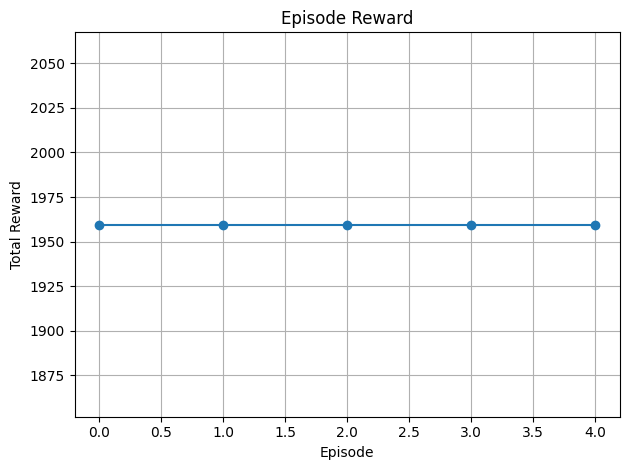

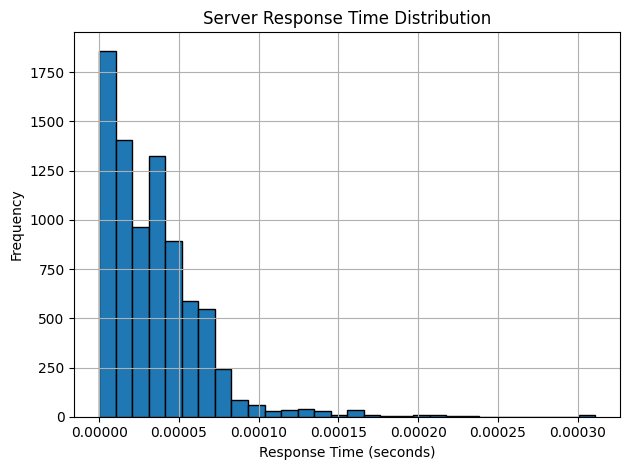

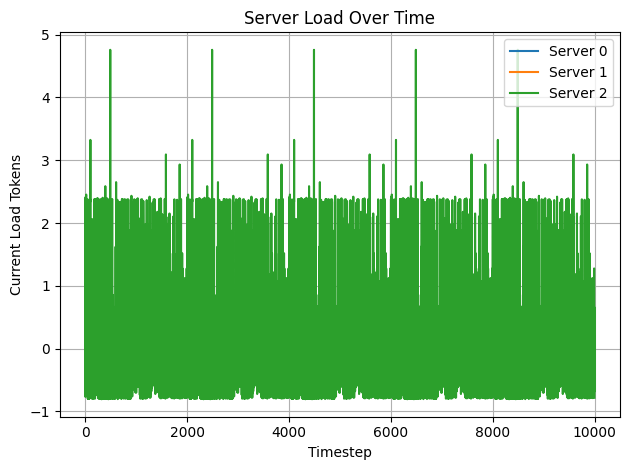

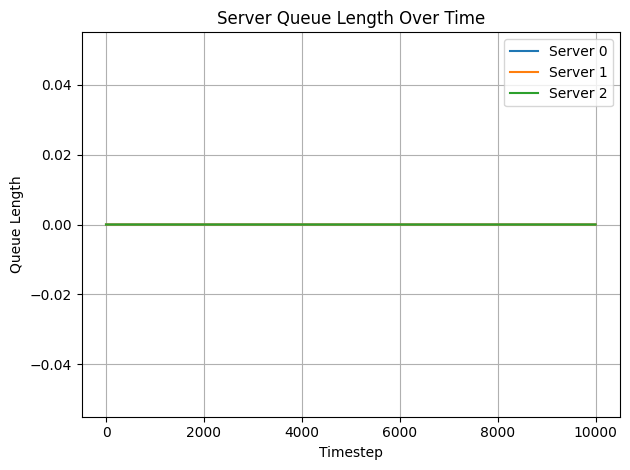

In [23]:
# Run evaluation and get metrics
eval_metrics = eval_model_performance(loaded_model, eval_env, n_eval_episodes=5)

# Plot reward per episode
plt.figure()
plt.plot(eval_metrics["rewards"], marker='o')
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.savefig("reward_per_episode.png", dpi=300)
plt.show()

# Plot server response time histogram
plt.figure()
plt.hist(eval_metrics["response_times"], bins=30, edgecolor='black')
plt.title("Server Response Time Distribution")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("response_time_distribution.png", dpi=300)
plt.show()

# Plot server load over time
plt.figure()
for server_id, loads in eval_metrics["server_loads"].items():
    plt.plot(loads, label=f"Server {server_id}")
plt.title("Server Load Over Time")
plt.xlabel("Timestep")
plt.ylabel("Current Load Tokens")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("server_load_over_time.png", dpi=300)
plt.show()

# Plot queue length over time
plt.figure()
for server_id, qlens in eval_metrics["queue_lengths"].items():
    plt.plot(qlens, label=f"Server {server_id}")
plt.title("Server Queue Length Over Time")
plt.xlabel("Timestep")
plt.ylabel("Queue Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("server_queue_length_over_time.png", dpi=300)
plt.show()

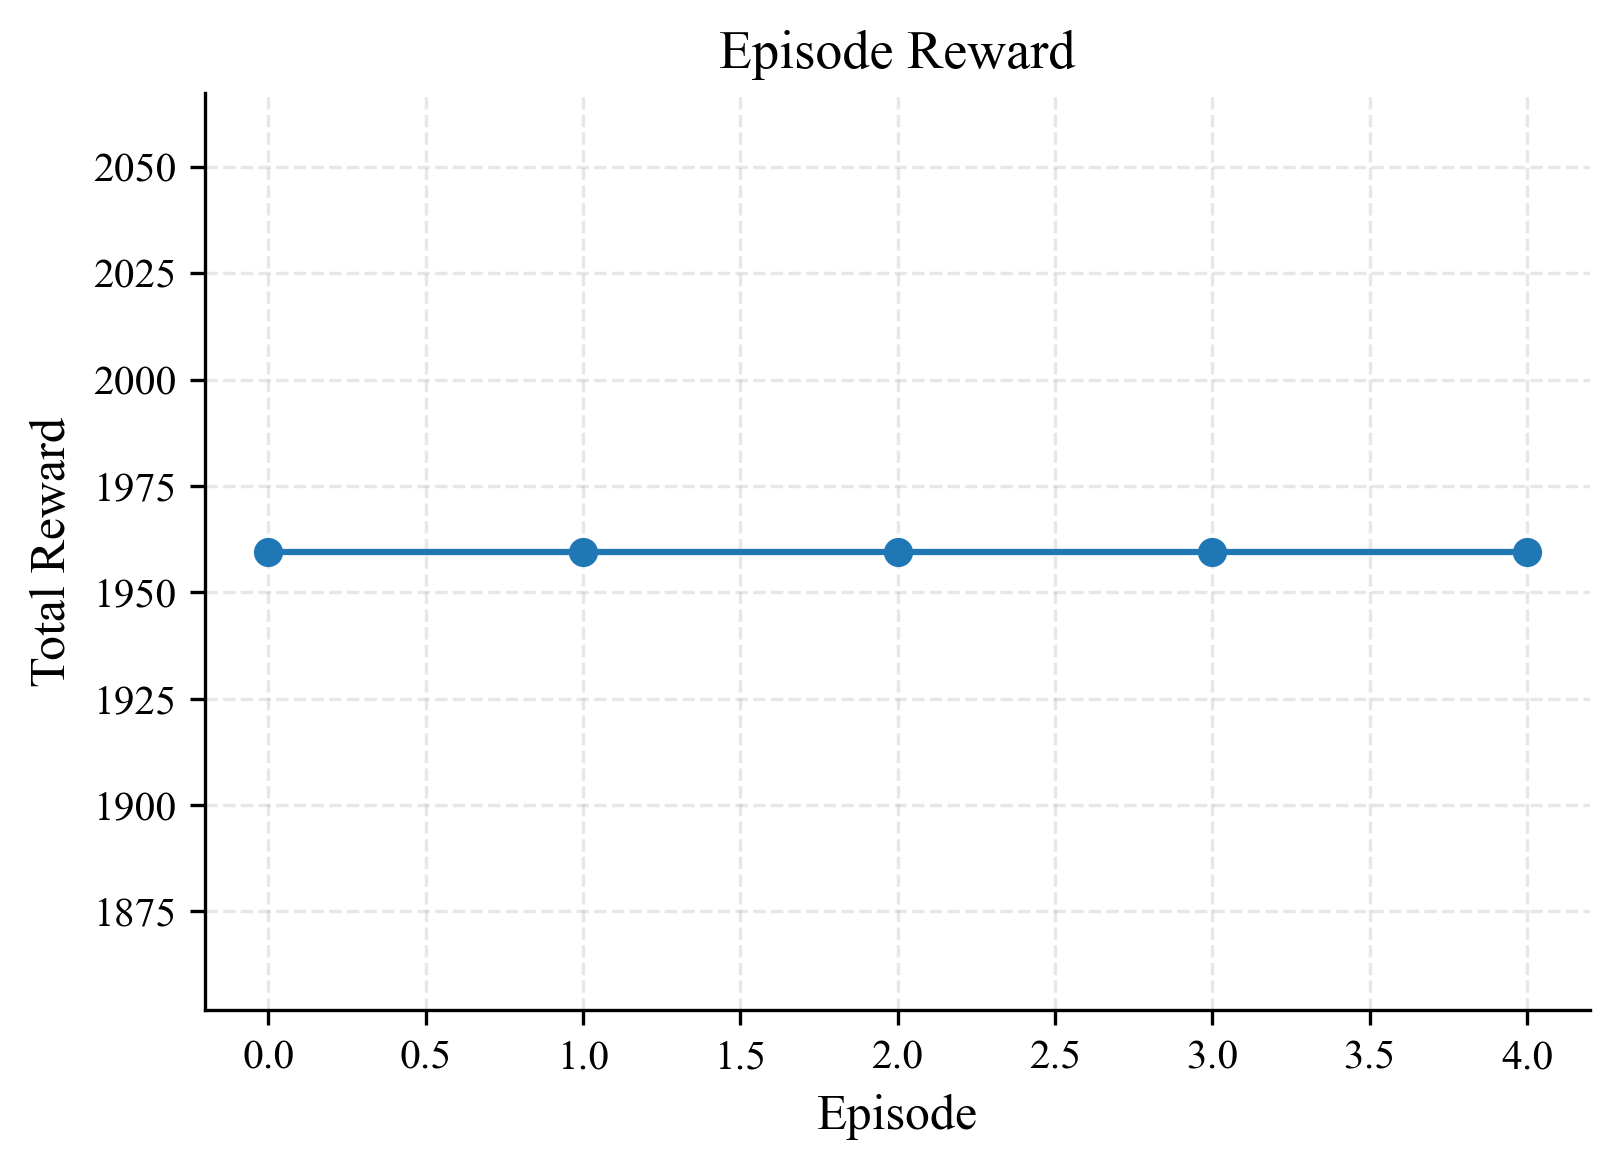

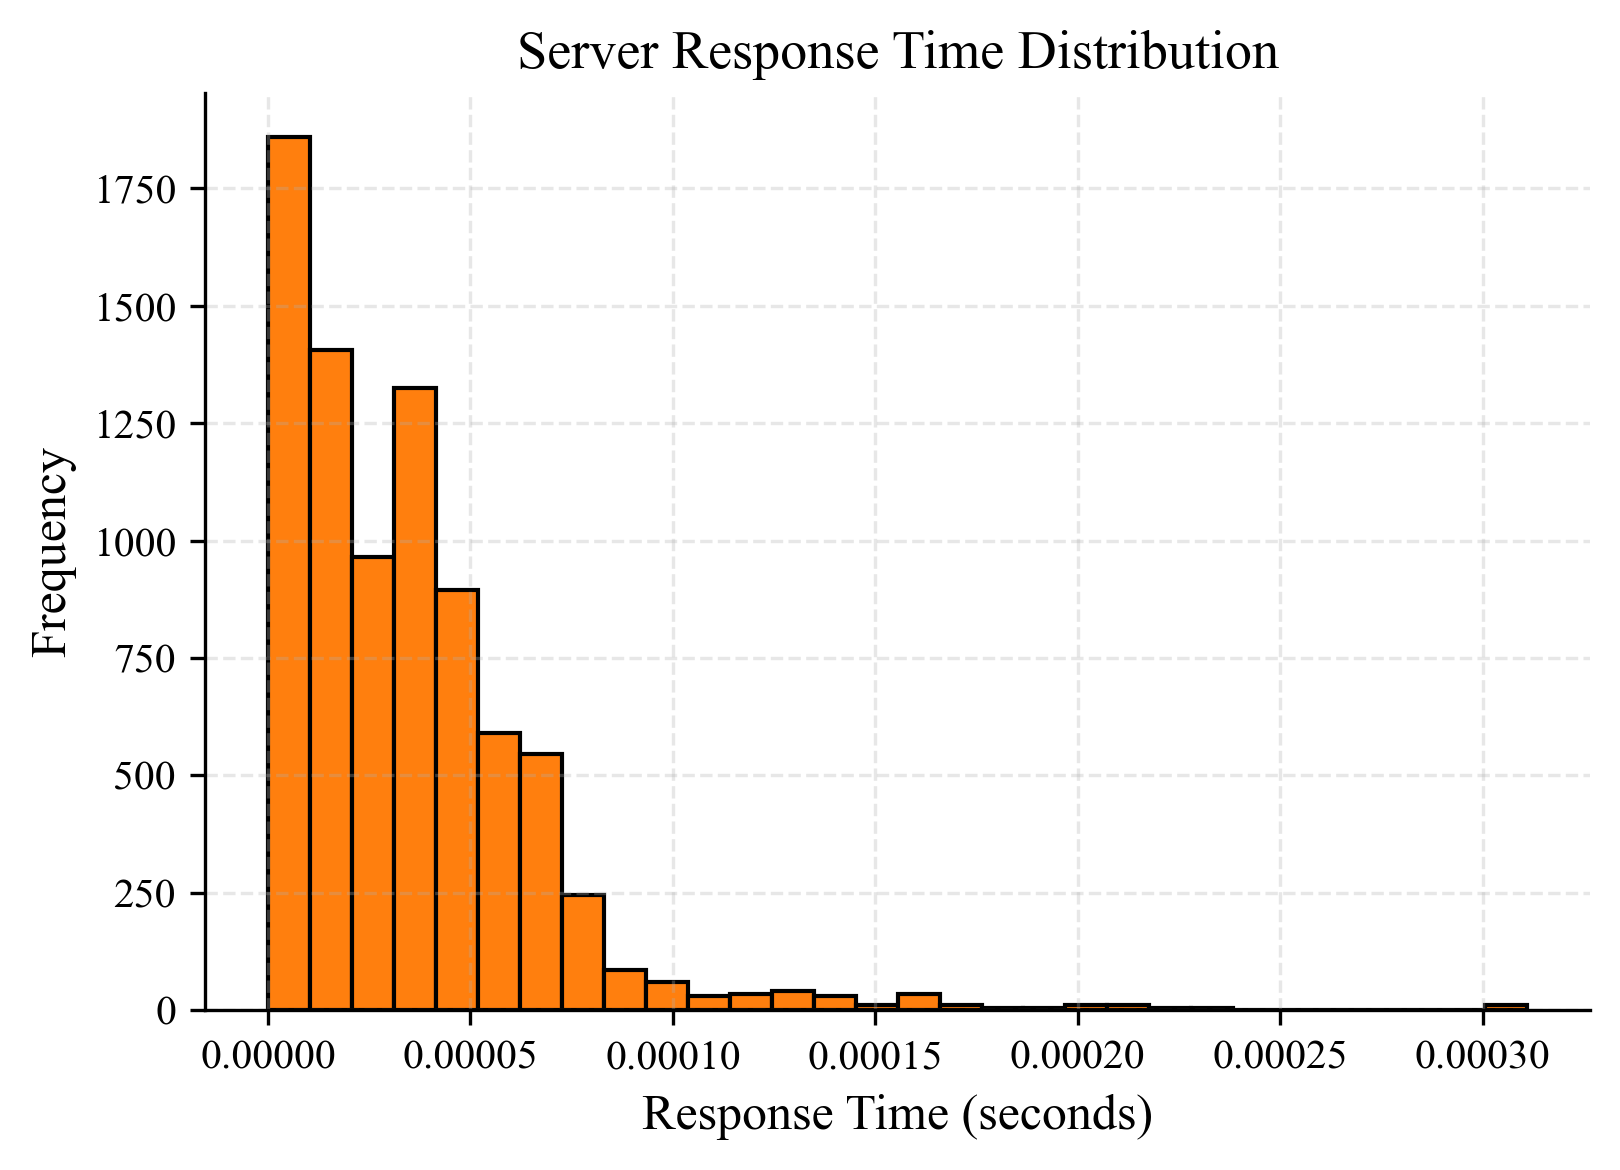

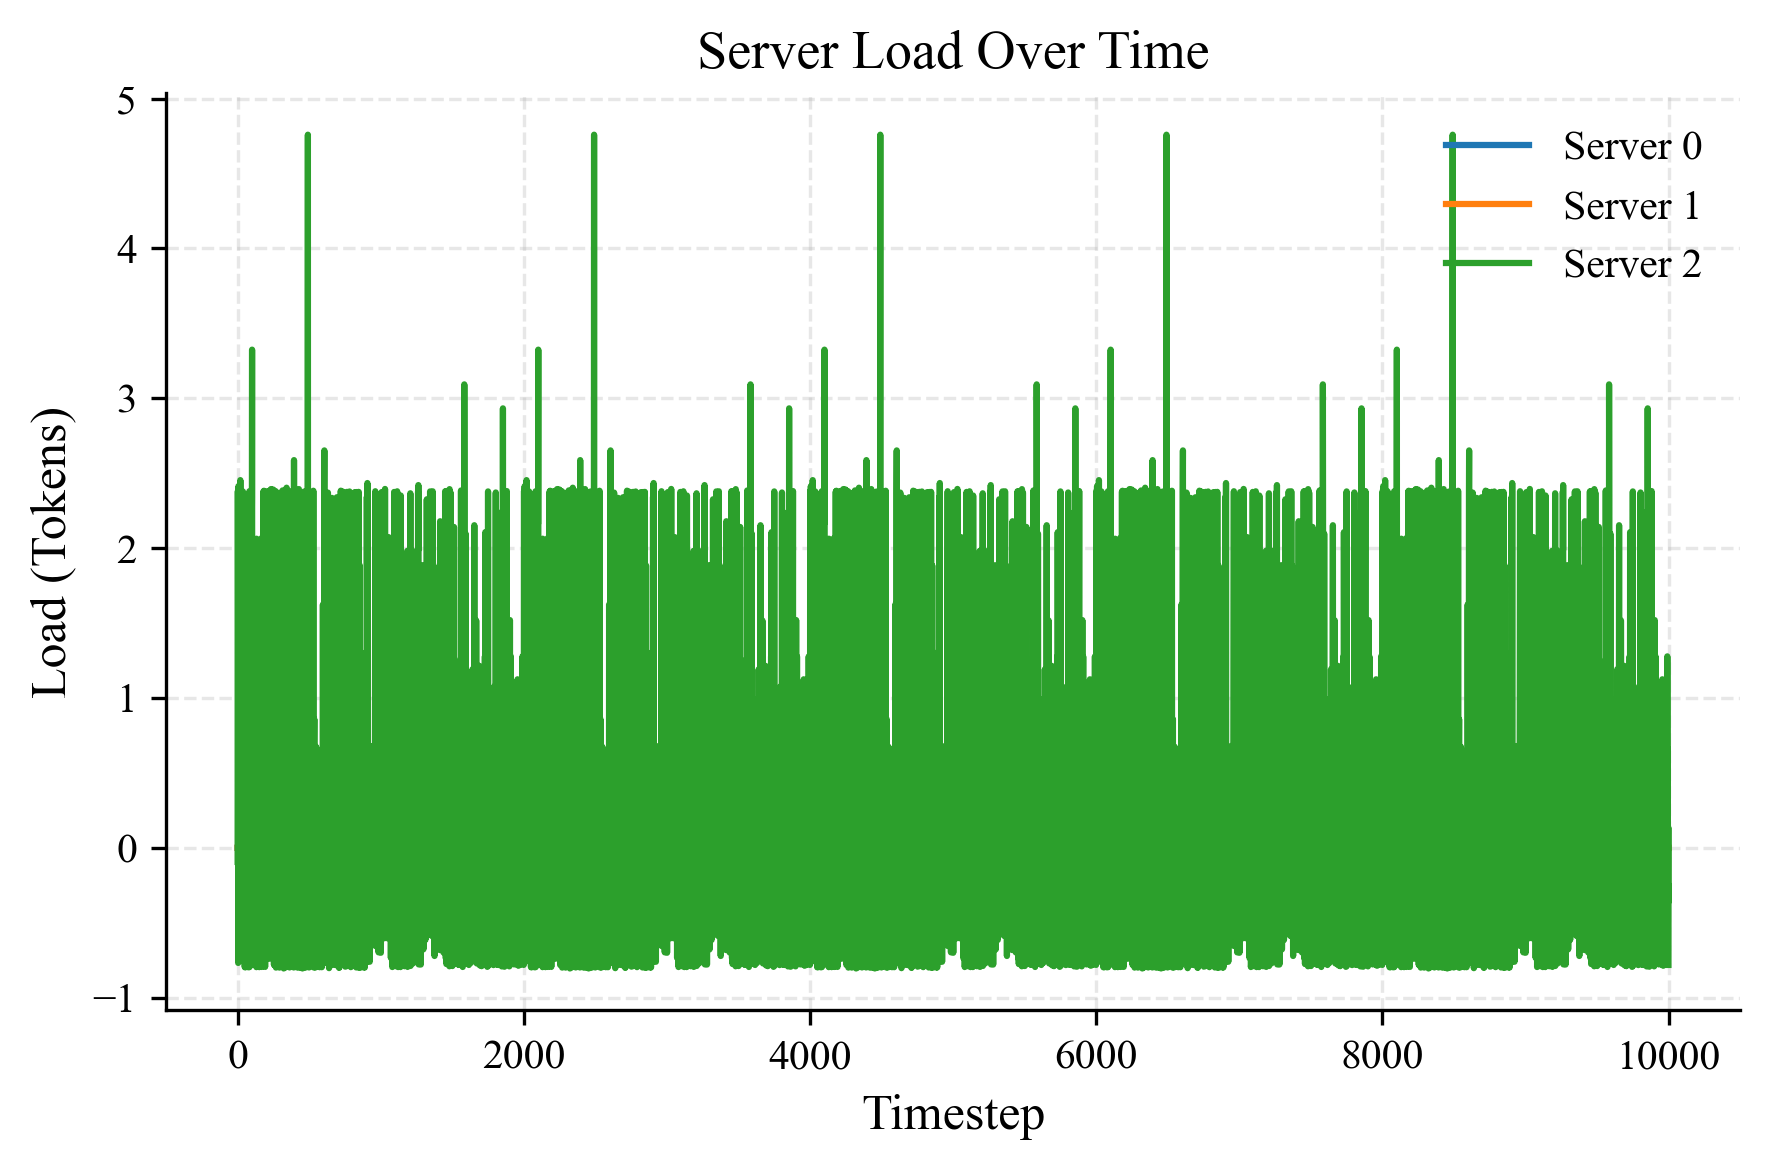

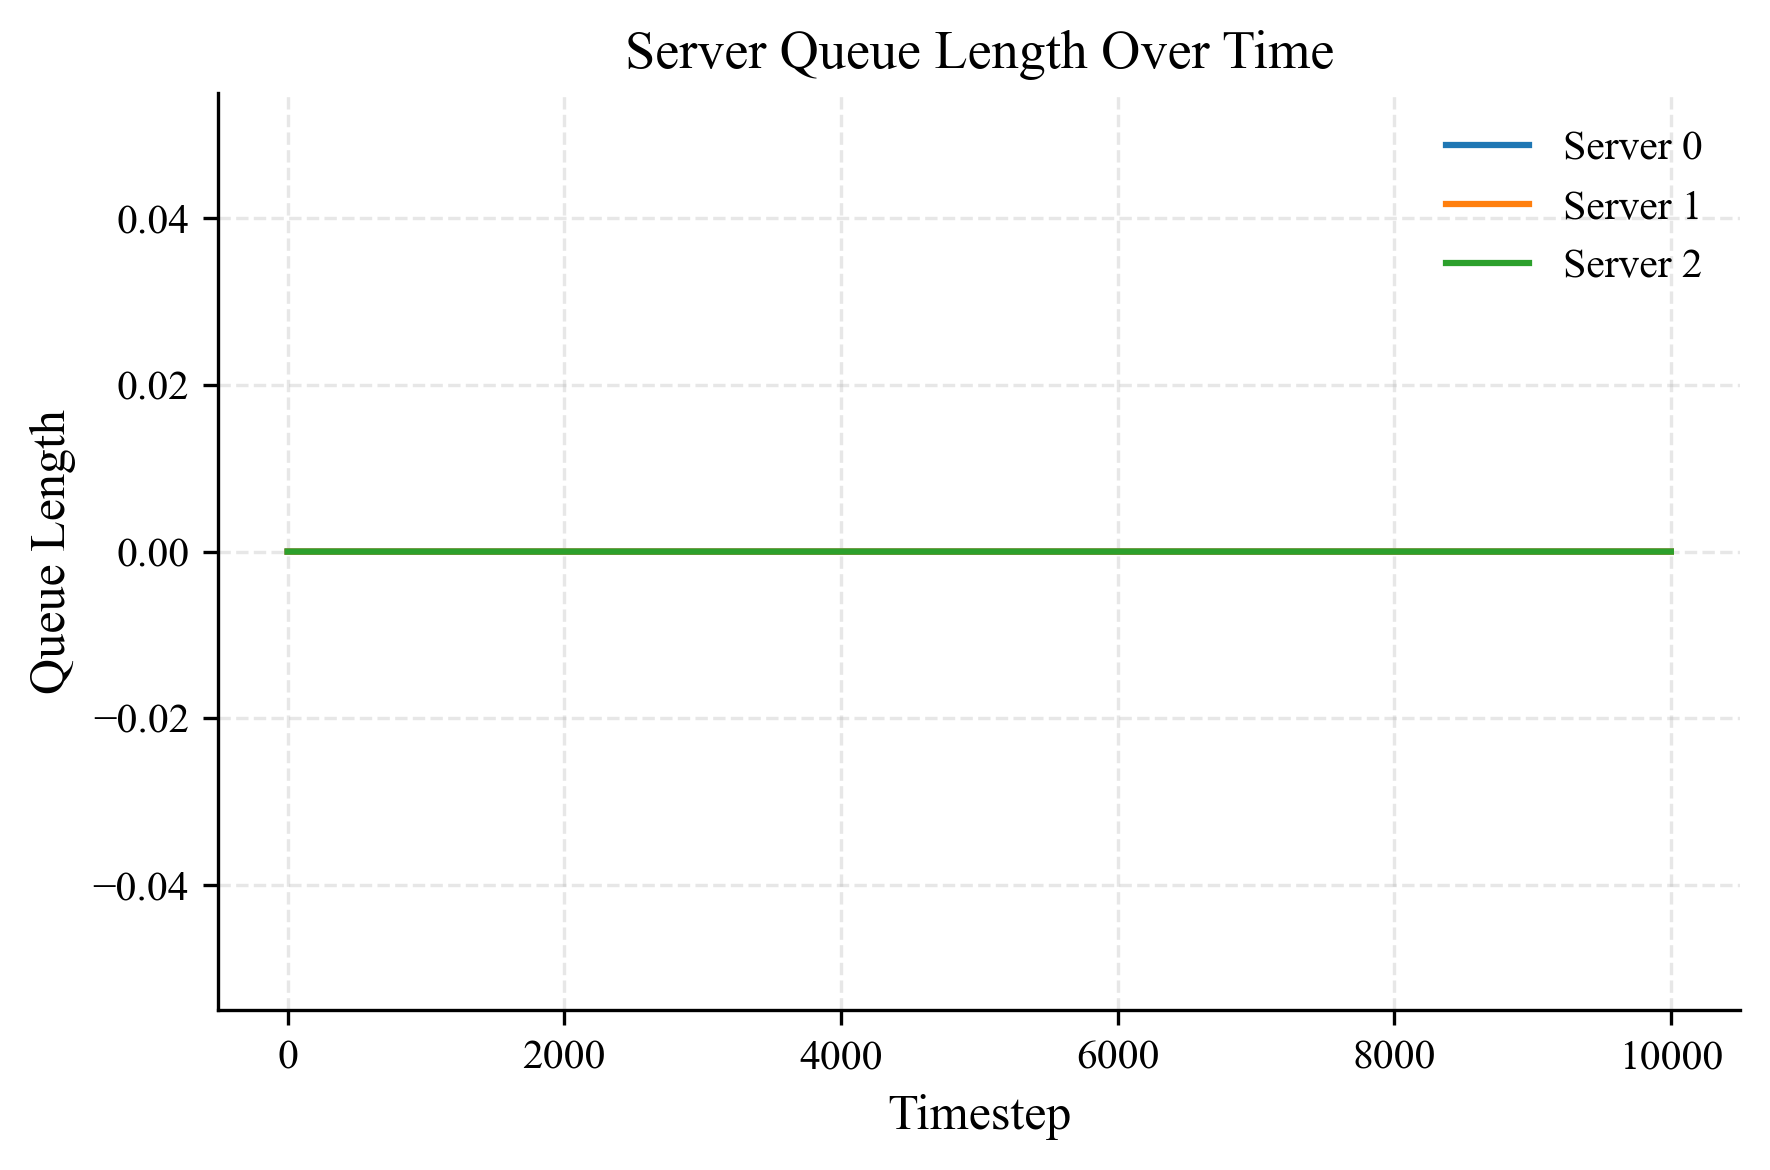

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use LaTeX-like fonts and styling
mpl.rcParams.update({
    "text.usetex": False,  # True if you have LaTeX installed
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Palatino"],
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# Colorblind-friendly palette
colors = plt.get_cmap("tab10")

# 1. Reward per episode
plt.figure(figsize=(5.5, 4))
plt.plot(eval_metrics["rewards"], marker='o', color=colors(0))
plt.title("Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.tight_layout()
plt.savefig("reward_per_episode.png", dpi=300)
plt.show()

# 2. Server Response Time Histogram
plt.figure(figsize=(5.5, 4))
plt.hist(eval_metrics["response_times"], bins=30, edgecolor='black', color=colors(1))
plt.title("Server Response Time Distribution")
plt.xlabel("Response Time (seconds)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("response_time_distribution.png", dpi=300)
plt.show()

# 3. Server Load Over Time
plt.figure(figsize=(6, 4))
for idx, (server_id, loads) in enumerate(eval_metrics["server_loads"].items()):
    plt.plot(loads, label=f"Server {server_id}", color=colors(idx))
plt.title("Server Load Over Time")
plt.xlabel("Timestep")
plt.ylabel("Load (Tokens)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("server_load_over_time.png", dpi=300)
plt.show()

# 4. Server Queue Length Over Time
plt.figure(figsize=(6, 4))
for idx, (server_id, qlens) in enumerate(eval_metrics["queue_lengths"].items()):
    plt.plot(qlens, label=f"Server {server_id}", color=colors(idx))
plt.title("Server Queue Length Over Time")
plt.xlabel("Timestep")
plt.ylabel("Queue Length")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("server_queue_length_over_time.png", dpi=300)
plt.show()

New Approach

PPO - Episode 1: Reward = 1955.92
PPO - Episode 2: Reward = 1959.13
PPO - Episode 3: Reward = 1955.87
PPO - Episode 4: Reward = 1959.59
PPO - Episode 5: Reward = 1956.70

PPO Final Results:
Mean Reward: 1957.44 ± 1.60
Mean Response Time: 0.000037 s

Round Robin - Episode 1: Reward = 1956.04
Round Robin - Episode 2: Reward = 1956.04
Round Robin - Episode 3: Reward = 1956.04
Round Robin - Episode 4: Reward = 1956.04
Round Robin - Episode 5: Reward = 1956.04

Round Robin Final Results:
Mean Reward: 1956.04 ± 0.00
Mean Response Time: 0.000034 s

Least Connections - Episode 1: Reward = 1956.04
Least Connections - Episode 2: Reward = 1956.04
Least Connections - Episode 3: Reward = 1956.04
Least Connections - Episode 4: Reward = 1956.04
Least Connections - Episode 5: Reward = 1956.04

Least Connections Final Results:
Mean Reward: 1956.04 ± 0.00
Mean Response Time: 0.000044 s

Least Loaded - Episode 1: Reward = 1956.04
Least Loaded - Episode 2: Reward = 1956.04
Least Loaded - Episode 3: Reward

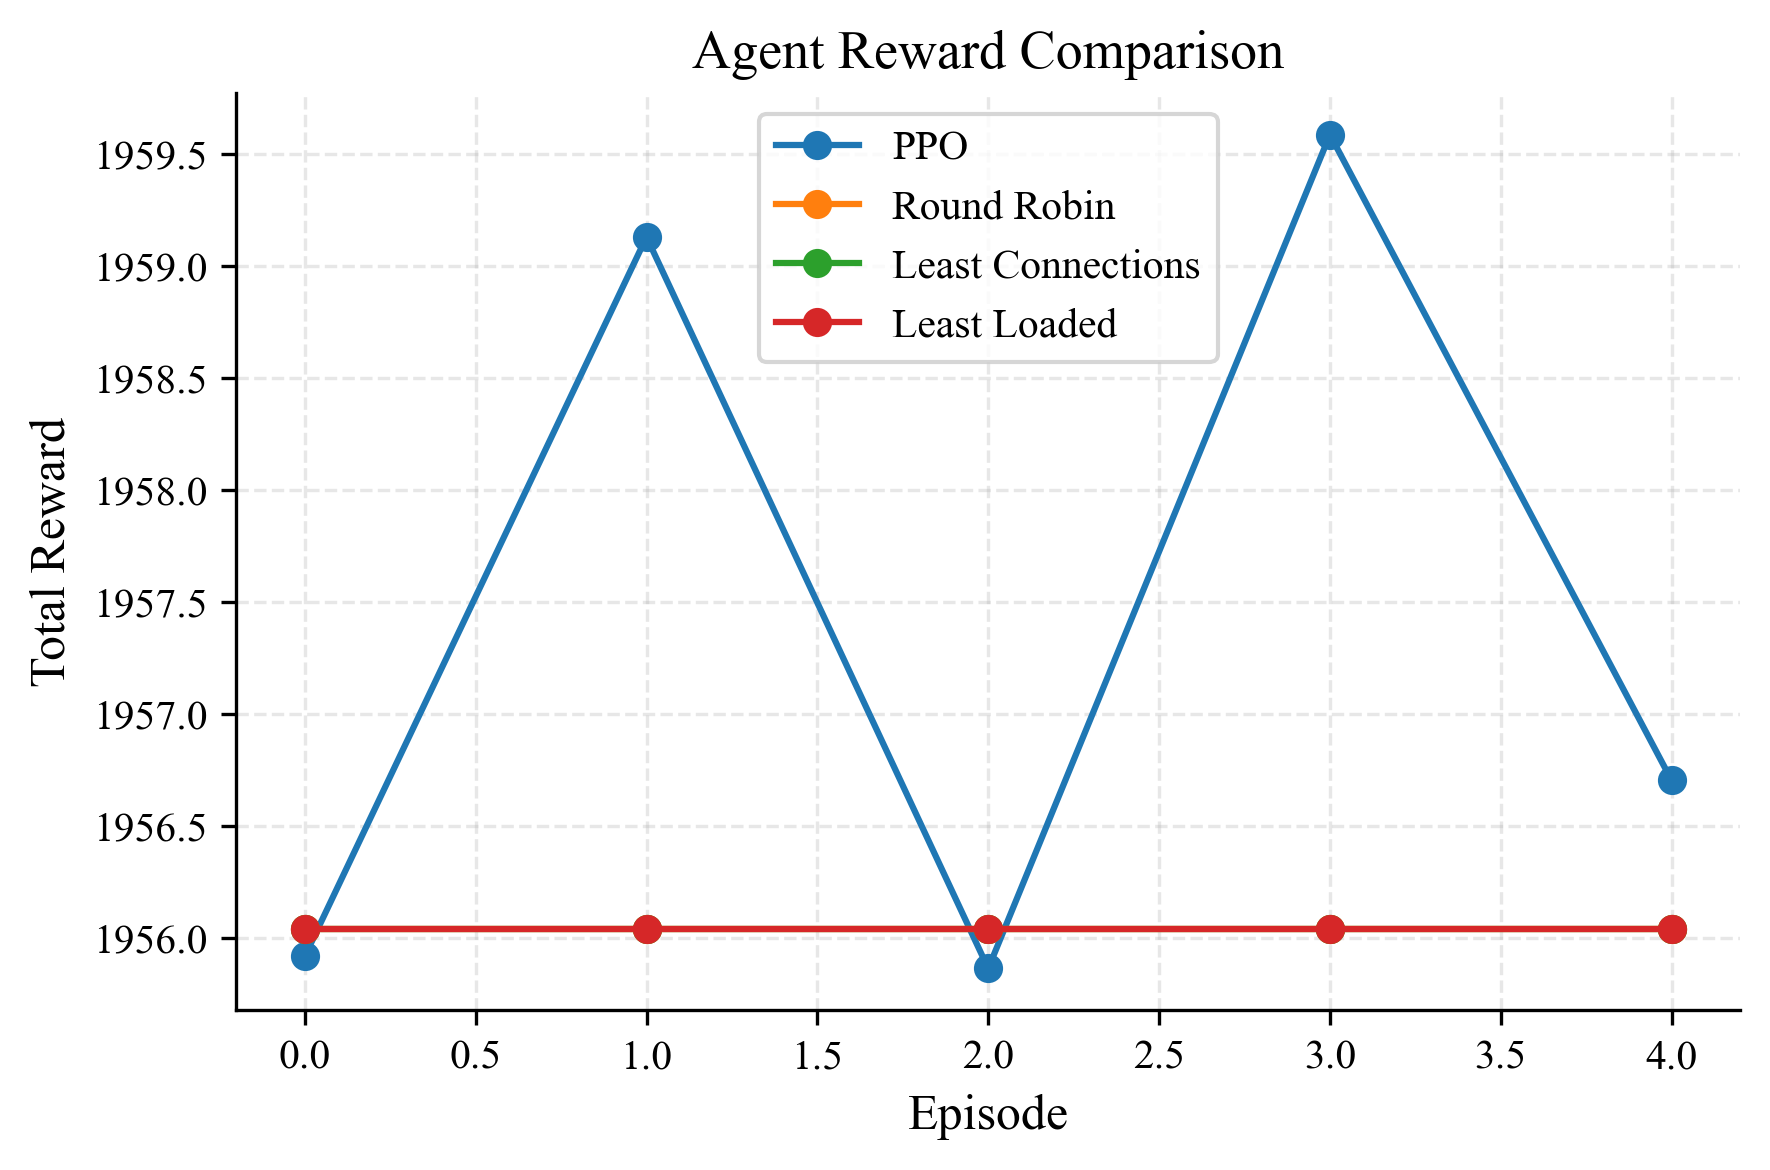

In [27]:
class RoundRobinAgent:
    def __init__(self, num_servers):
        self.num_servers = num_servers
        self.current = 0

    def predict(self, obs, deterministic=True):
        action = self.current
        self.current = (self.current + 1) % self.num_servers
        return action, None


class LeastConnectionsAgent:
    def __init__(self, env):
        self.env = env

    def predict(self, obs, deterministic=True):
        active_counts = [
            len(server['active_requests']) for server in self.env.servers
        ]
        action = int(np.argmin(active_counts))
        return action, None


class LeastLoadedAgent:
    def __init__(self, env):
        self.env = env

    def predict(self, obs, deterministic=True):
        loads = [server['current_load_tokens'] for server in self.env.servers]
        action = int(np.argmin(loads))
        return action, None

def __init__(self, trace_data, num_servers=3, server_configs=None,
             reward_weights=None, response_time_history_len=100):
    super().__init__()

    self.trace_data = trace_data.copy().sort_values(by='TIMESTAMP').reset_index(drop=True)
    self.num_servers = num_servers
    self.response_time_history_len = response_time_history_len

    self.reward_weights = reward_weights or {
        'response_time_penalty_per_sec': -0.01,
        'queue_penalty_per_item': -0.1,
        'overload_penalty': -10,
        'utilization_balance_reward_factor': 0.1,
        'request_completion_reward': 1
    }

    self.server_configs = server_configs or [
        {"rate": 5000, "max_concurrent": 5} for _ in range(self.num_servers)
    ]

    self.current_time = self.trace_data['TIMESTAMP'].iloc[0]
    self.servers = []
    for i in range(self.num_servers):
        config = self.server_configs[i]
        self.servers.append({
            'id': i,
            'processing_rate_tps': config['rate'],
            'max_concurrent_requests': config['max_concurrent'],
            'active_requests': [],
            'queue': collections.deque(),
            'current_load_tokens': 0,
            'last_request_finish_time': self.current_time,
            'processed_requests_count': 0,
            'total_processed_tokens': 0,
            'response_times': collections.deque(maxlen=self.response_time_history_len)
        })
def evaluate_agent(agent, env, agent_name="Agent", n_episodes=5):
    rewards = []
    response_times = []

    for ep in range(n_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = agent.predict(obs)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward

            for server_state in info.get('server_states', {}).values():
                avg_rt = server_state.get('avg_response_time', 0)
                if avg_rt > 0:
                    response_times.append(avg_rt)

        rewards.append(total_reward)
        print(f"{agent_name} - Episode {ep+1}: Reward = {total_reward:.2f}")

    print(f"\n{agent_name} Final Results:")
    print(f"Mean Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Mean Response Time: {np.mean(response_times):.6f} s\n")

    return rewards, response_times

# Re-create fresh env for each agent to avoid state leakage
ppo_env = LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3)
rr_env = LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3)
lc_env = LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3)
ll_env = LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3)

# Agents
ppo_agent = loaded_model
rr_agent = RoundRobinAgent(num_servers=3)
lc_agent = LeastConnectionsAgent(lc_env)
ll_agent = LeastLoadedAgent(ll_env)

# Evaluate
agent_rewards = {
    "PPO": evaluate_agent(ppo_agent, ppo_env, "PPO")[0],
    "Round Robin": evaluate_agent(rr_agent, rr_env, "Round Robin")[0],
    "Least Connections": evaluate_agent(lc_agent, lc_env, "Least Connections")[0],
    "Least Loaded": evaluate_agent(ll_agent, ll_env, "Least Loaded")[0],
}

# Plot
plt.figure(figsize=(6, 4))
for agent, rewards in agent_rewards.items():
    plt.plot(rewards, marker='o', label=agent)
plt.title("Agent Reward Comparison")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("agent_comparison.png", dpi=300)
plt.show()


A2C & DQN 

In [28]:
from stable_baselines3 import PPO

ppo_model = PPO("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
from stable_baselines3 import A2C, DQN

# A2C
a2c_model = A2C("MlpPolicy", train_env, verbose=1, tensorboard_log=LOG_DIR)

# DQN
dqn_model = DQN("MlpPolicy", train_env, verbose=1, tensorboard_log=LOG_DIR)

Using cpu device
Using cpu device


In [30]:
a2c_model.learn(total_timesteps=100_000)
a2c_model.save("a2c_model")

dqn_model.learn(total_timesteps=100_000)
dqn_model.save("dqn_model")

Logging to ./ppo_load_balancer_logs/A2C_1
------------------------------------
| time/                 |          |
|    fps                | 1262     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1       |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.99     |
|    value_loss         | 7.52     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1321     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.896   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 3.31   

In [33]:
from stable_baselines3 import A2C

loaded_a2c = A2C.load("a2c_model")

In [35]:
from stable_baselines3 import DQN

loaded_dqn = DQN.load("dqn_model")

In [36]:
agent_rewards = {
    "PPO": evaluate_agent(loaded_model, LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3))[0],
    "A2C": evaluate_agent(loaded_a2c, LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3))[0],
    "DQN": evaluate_agent(loaded_dqn, LoadBalancingEnv(trace_data=eval_trace_data, num_servers=3))[0],
    "Round Robin": evaluate_agent(rr_agent, rr_env)[0],
    
}

Agent - Episode 1: Reward = 1958.99
Agent - Episode 2: Reward = 1955.87
Agent - Episode 3: Reward = 1955.62
Agent - Episode 4: Reward = 1956.02
Agent - Episode 5: Reward = 1956.00

Agent Final Results:
Mean Reward: 1956.50 ± 1.26
Mean Response Time: 0.000036 s

Agent - Episode 1: Reward = 1959.57
Agent - Episode 2: Reward = 1959.57
Agent - Episode 3: Reward = 1959.57
Agent - Episode 4: Reward = 1959.57
Agent - Episode 5: Reward = 1959.57

Agent Final Results:
Mean Reward: 1959.57 ± 0.00
Mean Response Time: 0.000035 s

Agent - Episode 1: Reward = 1959.64
Agent - Episode 2: Reward = 1959.53
Agent - Episode 3: Reward = 1959.63
Agent - Episode 4: Reward = 1959.64
Agent - Episode 5: Reward = 1959.58

Agent Final Results:
Mean Reward: 1959.60 ± 0.04
Mean Response Time: 0.000056 s

Agent - Episode 1: Reward = 1956.04
Agent - Episode 2: Reward = 1956.04
Agent - Episode 3: Reward = 1956.04
Agent - Episode 4: Reward = 1956.04
Agent - Episode 5: Reward = 1956.04

Agent Final Results:
Mean Reward:

Goal:  Heterogeneous Servers, Higher Load, SLO Penality in Reward Function

In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import collections

class LoadBalancingEnv(gym.Env):
    def __init__(self, trace_data, server_configs=None, reward_weights=None, response_time_history_len=100):
        super().__init__()

        self.trace_data = trace_data.copy().sort_values(by='TIMESTAMP').reset_index(drop=True)
        self.response_time_history_len = response_time_history_len

        self.server_configs = server_configs or [
            {"rate": 3000, "max_concurrent": 3},
            {"rate": 5000, "max_concurrent": 5},
            {"rate": 7000, "max_concurrent": 7}
        ]
        self.num_servers = len(self.server_configs)

        self.reward_weights = reward_weights or {
            'response_time_penalty_per_sec': -0.01,
            'queue_penalty_per_item': -0.1,
            'overload_penalty': -10,
            'utilization_balance_reward_factor': 0.1,
            'request_completion_reward': 1,
            'slo_violation_penalty': -5,
            'slo_threshold_sec': 0.1
        }

        self.servers = []
        self.current_step = 0
        self.done = False
        self.current_request_idx = 0
        self.current_time = self.trace_data['TIMESTAMP'].iloc[0]

        for i, config in enumerate(self.server_configs):
            self.servers.append({
                'id': i,
                'processing_rate_tps': config['rate'],
                'max_concurrent_requests': config['max_concurrent'],
                'active_requests': [],
                'queue': collections.deque(),
                'current_load_tokens': 0,
                'last_request_finish_time': self.current_time,
                'processed_requests_count': 0,
                'total_processed_tokens': 0,
                'response_times': collections.deque(maxlen=response_time_history_len)
            })

        self.observation_space = spaces.Box(low=0, high=1e6, shape=(10 + 5 * self.num_servers,), dtype=np.float32)
        self.action_space = spaces.Discrete(self.num_servers)

    def _get_obs(self, request):
        req_features = [
            request['TotalTokens'],
            request['ContextTokens'],
            request['GeneratedTokens'],
            request['HourOfDay'],
            request['DayOfWeek'],
            request['TotalTokens_last_5_mean'],
            request['TotalTokens_last_5_std'],
            request['TotalTokens_lag_1'],
            request['ContextTokens_last_5_mean'],
            request['GeneratedTokens_last_5_mean'],
        ]

        srv_features = []
        for server in self.servers:
            util = len(server['active_requests']) / server['max_concurrent_requests']
            wait = sum(req['total_tokens'] for req in server['queue']) / server['processing_rate_tps']
            avg_rt = np.mean(server['response_times']) if server['response_times'] else 0.0
            srv_features.extend([
                server['current_load_tokens'],
                len(server['queue']),
                util,
                wait,
                avg_rt
            ])
        return np.array(req_features + srv_features, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.done = False
        self.current_request_idx = 0
        self.current_time = self.trace_data['TIMESTAMP'].iloc[0]

        for server in self.servers:
            server.update({
                'active_requests': [],
                'queue': collections.deque(),
                'current_load_tokens': 0,
                'last_request_finish_time': self.current_time,
                'processed_requests_count': 0,
                'total_processed_tokens': 0,
                'response_times': collections.deque(maxlen=self.response_time_history_len)
            })

        request = self.trace_data.iloc[self.current_request_idx]
        return self._get_obs(request), {}

    def _update_server_states(self, current_time):
        for server in self.servers:
            completed = [r for r in server['active_requests'] if r['finish_time'] <= current_time]
            for r in completed:
                server['active_requests'].remove(r)
                server['current_load_tokens'] -= r['total_tokens']
                rt = (r['finish_time'] - r['start_time']).total_seconds()
                server['response_times'].append(rt)
            while server['queue'] and len(server['active_requests']) < server['max_concurrent_requests']:
                q = server['queue'].popleft()
                start = max(current_time, server['last_request_finish_time'])
                duration = q['total_tokens'] / server['processing_rate_tps']
                finish = start + pd.Timedelta(seconds=duration)
                server['active_requests'].append({
                    'request_id': q['request_id'],
                    'total_tokens': q['total_tokens'],
                    'start_time': start,
                    'finish_time': finish
                })
                server['current_load_tokens'] += q['total_tokens']
                server['last_request_finish_time'] = finish

    def step(self, action):
        if self.done:
            return self.observation_space.sample(), 0.0, True, False, {}

        request = self.trace_data.iloc[self.current_request_idx]
        arrival_time = request['TIMESTAMP']
        self.current_time = arrival_time
        self._update_server_states(self.current_time)

        server = self.servers[action]
        total_tokens = request['TotalTokens']
        proc_duration = total_tokens / server['processing_rate_tps']
        finish_time = self.current_time + pd.Timedelta(seconds=proc_duration)

        reward = 0
        was_queued = False

        if len(server['active_requests']) >= server['max_concurrent_requests']:
            server['queue'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'arrival_time': arrival_time,
                'estimated_processing_duration': proc_duration
            })
            was_queued = True
        else:
            server['active_requests'].append({
                'request_id': self.current_request_idx,
                'total_tokens': total_tokens,
                'start_time': arrival_time,
                'finish_time': finish_time
            })
            server['current_load_tokens'] += total_tokens

        # Compute reward
        resp_penalty = self.reward_weights['response_time_penalty_per_sec'] * proc_duration
        queue_penalty = self.reward_weights['queue_penalty_per_item'] * len(server['queue'])
        overload_penalty = self.reward_weights['overload_penalty'] if was_queued else 0

        slo_threshold = self.reward_weights['slo_threshold_sec']
        slo_penalty = self.reward_weights['slo_violation_penalty'] if proc_duration > slo_threshold else 0

        utilization = [s['current_load_tokens'] for s in self.servers]
        mean = np.mean(utilization)
        std = np.std(utilization)
        balance = 1 - (std / mean) if mean > 0 else 1
        balance_reward = self.reward_weights['utilization_balance_reward_factor'] * balance

        reward = resp_penalty + queue_penalty + overload_penalty + balance_reward + slo_penalty + \
                 self.reward_weights['request_completion_reward']

        self.current_request_idx += 1
        if self.current_request_idx >= len(self.trace_data):
            self.done = True
            next_obs = self._get_obs(self.trace_data.iloc[-1])
        else:
            next_obs = self._get_obs(self.trace_data.iloc[self.current_request_idx])

        return next_obs, reward, self.done, False, {
            "server_states": {s['id']: {
                "queue_length": len(s['queue']),
                "avg_response_time": np.mean(s['response_times']) if s['response_times'] else 0
            } for s in self.servers}
        }

    def render(self):
        pass

Simulate High Load Trace

In [15]:
df_traces["Coding"].columns.tolist()

df_traces["Coding"].head()

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-10 00:00:00.009930+00:00,2162,5
1,2024-05-10 00:00:00.017335+00:00,2399,6
2,2024-05-10 00:00:00.022314+00:00,76,15
3,2024-05-10 00:00:00.037845+00:00,2376,1
4,2024-05-10 00:00:00.083890+00:00,7670,8


In [16]:
import numpy as np
import pandas as pd

# Copy and sort your high-load slice
df_high_load = df_traces["Coding"].iloc[:5000].copy()
df_high_load['TIMESTAMP'] = pd.to_datetime(df_high_load['TIMESTAMP'])
df_high_load['TIMESTAMP'] = df_high_load['TIMESTAMP'] - pd.to_timedelta(np.linspace(0, 1000, len(df_high_load)), unit='s')
df_high_load = df_high_load.sort_values('TIMESTAMP').reset_index(drop=True)

# Compute required columns
df_high_load['TotalTokens'] = df_high_load['ContextTokens'] + df_high_load['GeneratedTokens']

# Temporal features
df_high_load['HourOfDay'] = df_high_load['TIMESTAMP'].dt.hour
df_high_load['DayOfWeek'] = df_high_load['TIMESTAMP'].dt.dayofweek

# Rolling and lag features
df_high_load['TotalTokens_last_5_mean'] = df_high_load['TotalTokens'].rolling(window=5).mean().bfill()
df_high_load['TotalTokens_last_5_std'] = df_high_load['TotalTokens'].rolling(window=5).std().fillna(0)
df_high_load['TotalTokens_lag_1'] = df_high_load['TotalTokens'].shift(1).bfill()
df_high_load['ContextTokens_last_5_mean'] = df_high_load['ContextTokens'].rolling(window=5).mean().bfill()
df_high_load['GeneratedTokens_last_5_mean'] = df_high_load['GeneratedTokens'].rolling(window=5).mean().bfill()

# Quick check
print("✅ df_high_load is ready.")
display(df_high_load.head())

✅ df_high_load is ready.


,TIMESTAMP,ContextTokens,GeneratedTokens,TotalTokens,HourOfDay,DayOfWeek,TotalTokens_last_5_mean,TotalTokens_last_5_std,TotalTokens_lag_1,ContextTokens_last_5_mean,GeneratedTokens_last_5_mean
0,2024-05-09 23:46:51.341907+00:00,2257,14,2271,23,3,1756.4,0.000000,2271.0,1739.2,17.2
1,2024-05-09 23:46:51.539748008+00:00,613,13,626,23,3,1756.4,0.000000,2271.0,1739.2,17.2
2,2024-05-09 23:46:51.693602016+00:00,5379,16,5395,23,3,1756.4,0.000000,626.0,1739.2,17.2
3,2024-05-09 23:46:51.853190024+00:00,61,20,81,23,3,1756.4,0.000000,5395.0,1739.2,17.2
4,2024-05-09 23:46:51.947688032+00:00,386,23,409,23,3,1756.4,2202.525777,81.0,1739.2,17.2


In [17]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

env_config = {
    "trace_data": df_high_load,
    "server_configs": [
        {"rate": 3000, "max_concurrent": 3},
        {"rate": 5000, "max_concurrent": 5},
        {"rate": 7000, "max_concurrent": 7}
    ]
}

train_env = make_vec_env(LoadBalancingEnv, n_envs=1, env_kwargs=env_config)

ppo = PPO("MlpPolicy", train_env, verbose=1)
ppo.learn(total_timesteps=200_000)
ppo.save("ppo_stressed")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2569 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 2024       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01276559 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.00181    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.27e+04   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0254    |
|    value_loss           | 2.64e+04   |
----------------------------------------
-----------------------------------

Full step() Method (with SLO penalty + logging)

In [18]:
def step(self, action):
    if self.done:
        print("Warning: Calling step() on a finished episode. Reset the environment.")
        return np.zeros_like(self.observation_space.low), 0.0, True, False, {}

    current_request = self.trace_data.iloc[self.current_request_idx]
    request_arrival_time = current_request['TIMESTAMP']

    self.current_time = request_arrival_time
    self._update_server_states(self.current_time)

    chosen_server_id = action
    reward = 0
    truncated = False

    server_at_capacity_before_decision = (
        len(self.servers[chosen_server_id]['active_requests']) >=
        self.servers[chosen_server_id]['max_concurrent_requests']
    )

    was_queued, immediate_processing_cost_for_reward = self._process_request_on_server(
        chosen_server_id, current_request, self.current_time
    )

    # === Reward Components ===
    response_time_reward = self.reward_weights['response_time_penalty_per_sec'] * immediate_processing_cost_for_reward
    queue_penalty = self.reward_weights['queue_penalty_per_item'] * len(self.servers[chosen_server_id]['queue'])
    overload_penalty = self.reward_weights['overload_penalty'] if server_at_capacity_before_decision else 0

    current_server_loads = [s['current_load_tokens'] for s in self.servers]
    if len(current_server_loads) > 1 and np.sum(current_server_loads) > 0:
        mean_load = np.mean(current_server_loads)
        std_load = np.std(current_server_loads)
        balance_metric = 1 - (std_load / mean_load) if mean_load > 0 else 1
        utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor'] * balance_metric
    elif len(current_server_loads) == 1:
        utilization_balance_reward = self.reward_weights['utilization_balance_reward_factor']
    else:
        utilization_balance_reward = 0

    request_completion_reward = self.reward_weights['request_completion_reward']

    # === SLO Penalty ===
    SLO_THRESHOLD_SEC = 0.1  # 100ms
    SLO_PENALTY = -5.0
    violating_responses = [
        rt for rt in self.servers[chosen_server_id]['response_times']
        if rt > SLO_THRESHOLD_SEC
    ]
    slo_penalty = SLO_PENALTY * len(violating_responses)

    # === Final Reward ===
    reward = (
        response_time_reward +
        queue_penalty +
        overload_penalty +
        utilization_balance_reward +
        request_completion_reward +
        slo_penalty
    )

    # === Advance to next request ===
    self.current_request_idx += 1
    if self.current_request_idx >= len(self.trace_data):
        self.done = True
        next_observation = self._get_obs(self.trace_data.iloc[-1])
    else:
        next_request = self.trace_data.iloc[self.current_request_idx]
        next_observation = self._get_obs(next_request)

    # === Logging Info ===
    info = {
        'chosen_server': chosen_server_id,
        'request_id': self.current_request_idx - 1,
        'request_total_tokens': current_request['TotalTokens'],
        'estimated_processing_time_of_this_request': current_request['TotalTokens'] / self.servers[chosen_server_id]['processing_rate_tps'],
        'was_queued': was_queued,
        'server_states': {
            s['id']: {
                'active_requests': len(s['active_requests']),
                'queue_length': len(s['queue']),
                'current_load_tokens': s['current_load_tokens'],
                'avg_response_time': np.mean(s['response_times']) if s['response_times'] else 0
            } for s in self.servers
        },
        'reward_components': {
            'response_time_penalty_per_sec': response_time_reward,
            'queue_penalty_per_item': queue_penalty,
            'overload_penalty': overload_penalty,
            'utilization_balance_reward': utilization_balance_reward,
            'request_completion_reward': request_completion_reward,
            'slo_penalty': slo_penalty
        }
    }

    return next_observation, reward, self.done, truncated, info

In [19]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

env_config = {
    "trace_data": df_high_load,
    "server_configs": [
        {"rate": 3000, "max_concurrent": 3},
        {"rate": 5000, "max_concurrent": 5},
        {"rate": 7000, "max_concurrent": 7}
    ]
}

train_env = make_vec_env(LoadBalancingEnv, n_envs=1, env_kwargs=env_config)
ppo = PPO("MlpPolicy", train_env, verbose=1)
ppo.learn(total_timesteps=200_000)
ppo.save("ppo_slo_aware")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2429 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1974       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01223324 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.00201    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.42e+04   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0229    |
|    value_loss           | 2.89e+04   |
----------------------------------------
-----------------------------------

In [22]:
def evaluate_agent(agent, env, agent_name="Agent", n_episodes=5, slo_threshold=0.1):
    rewards = []
    response_times = []
    slo_violations_per_episode = []

    for ep in range(n_episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0
        slo_violations = 0

        while not done:
            action, _ = agent.predict(obs)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward

            # Check SLO violations from info
            for server_state in info.get("server_states", {}).values():
                rt = server_state.get("avg_response_time", 0)
                response_times.append(rt)
                if rt > slo_threshold:
                    slo_violations += 1

        rewards.append(total_reward)
        slo_violations_per_episode.append(slo_violations)
        print(f"{agent_name} - Episode {ep+1}: Reward = {total_reward:.2f}, SLO Violations = {slo_violations}")

    print(f"\n{agent_name} Final Results:")
    print(f"Mean Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Mean Response Time: {np.mean(response_times):.6f} s")
    print(f"Avg SLO Violations per Episode: {np.mean(slo_violations_per_episode):.2f}\n")

    return rewards, slo_violations_per_episode
class RoundRobinAgent:
    def __init__(self, num_servers):
        self.num_servers = num_servers
        self.current = 0

    def predict(self, obs, deterministic=True):
        action = self.current
        self.current = (self.current + 1) % self.num_servers
        return action, None

class LeastConnectionsAgent:
    def __init__(self, env):
        self.env = env

    def predict(self, obs, deterministic=True):
        active_counts = [len(server['active_requests']) for server in self.env.servers]
        return int(np.argmin(active_counts)), None

class LeastLoadedAgent:
    def __init__(self, env):
        self.env = env

    def predict(self, obs, deterministic=True):
        loads = [server['current_load_tokens'] for server in self.env.servers]
        return int(np.argmin(loads)), None

eval_env_config = {
    "trace_data": df_high_load,
    "server_configs": [
        {"rate": 3000, "max_concurrent": 3},
        {"rate": 5000, "max_concurrent": 5},
        {"rate": 7000, "max_concurrent": 7}
    ]
}

ppo_loaded = PPO.load("ppo_slo_aware")
ppo_eval_env = LoadBalancingEnv(**eval_env_config)
rr_agent = RoundRobinAgent(num_servers=3)
lc_agent = LeastConnectionsAgent(ppo_eval_env)
ll_agent = LeastLoadedAgent(ppo_eval_env)

# Evaluate
ppo_rewards, _ = evaluate_agent(ppo_loaded, LoadBalancingEnv(**eval_env_config), agent_name="PPO SLO")
rr_rewards, _ = evaluate_agent(rr_agent, LoadBalancingEnv(**eval_env_config), agent_name="Round Robin")
lc_rewards, _ = evaluate_agent(lc_agent, LoadBalancingEnv(**eval_env_config), agent_name="Least Connections")
ll_rewards, _ = evaluate_agent(ll_agent, LoadBalancingEnv(**eval_env_config), agent_name="Least Loaded")

# Store for plotting
agent_rewards = {
    "PPO SLO": ppo_rewards,
    "Round Robin": rr_rewards,
    "Least Connections": lc_rewards,
    "Least Loaded": ll_rewards
}

PPO SLO - Episode 1: Reward = -15231.99, SLO Violations = 14965
PPO SLO - Episode 2: Reward = -15222.34, SLO Violations = 14970
PPO SLO - Episode 3: Reward = -15204.74, SLO Violations = 14951
PPO SLO - Episode 4: Reward = -15192.65, SLO Violations = 14964
PPO SLO - Episode 5: Reward = -15225.52, SLO Violations = 14973

PPO SLO Final Results:
Mean Reward: -15215.45 ± 14.54
Mean Response Time: 0.885588 s
Avg SLO Violations per Episode: 14964.60

Round Robin - Episode 1: Reward = -89504.86, SLO Violations = 14987
Round Robin - Episode 2: Reward = -93730.98, SLO Violations = 14988
Round Robin - Episode 3: Reward = -74504.38, SLO Violations = 14981
Round Robin - Episode 4: Reward = -89504.86, SLO Violations = 14987
Round Robin - Episode 5: Reward = -93730.98, SLO Violations = 14988

Round Robin Final Results:
Mean Reward: -88195.21 ± 7101.53
Mean Response Time: 0.552597 s
Avg SLO Violations per Episode: 14986.20

Least Connections - Episode 1: Reward = -1081110.78, SLO Violations = 4997
Lea

PPO SLO - Episode 1: Reward = -15216.07, SLO Violations = 14975
PPO SLO - Episode 2: Reward = -15230.51, SLO Violations = 14966
PPO SLO - Episode 3: Reward = -15219.52, SLO Violations = 14973
PPO SLO - Episode 4: Reward = -15213.08, SLO Violations = 14975
PPO SLO - Episode 5: Reward = -15220.28, SLO Violations = 14967

PPO SLO Final Results:
Mean Reward: -15219.89 ± 5.90
Mean Response Time: 0.887974 s
Avg SLO Violations per Episode: 14971.20

Round Robin - Episode 1: Reward = -74504.38, SLO Violations = 14981
Round Robin - Episode 2: Reward = -89504.86, SLO Violations = 14987
Round Robin - Episode 3: Reward = -93730.98, SLO Violations = 14988
Round Robin - Episode 4: Reward = -74504.38, SLO Violations = 14981
Round Robin - Episode 5: Reward = -89504.86, SLO Violations = 14987

Round Robin Final Results:
Mean Reward: -84349.89 ± 8185.60
Mean Response Time: 0.548901 s
Avg SLO Violations per Episode: 14984.80

Least Connections - Episode 1: Reward = -1081110.78, SLO Violations = 4997
Leas

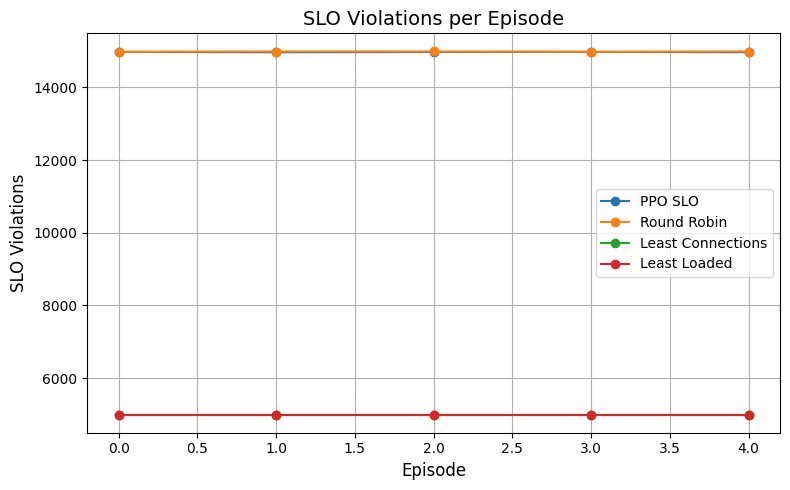

In [23]:
import matplotlib.pyplot as plt

agent_slo_violations = {
    "PPO SLO": evaluate_agent(ppo_loaded, LoadBalancingEnv(**eval_env_config), agent_name="PPO SLO")[1],
    "Round Robin": evaluate_agent(rr_agent, LoadBalancingEnv(**eval_env_config), agent_name="Round Robin")[1],
    "Least Connections": evaluate_agent(lc_agent, LoadBalancingEnv(**eval_env_config), agent_name="Least Connections")[1],
    "Least Loaded": evaluate_agent(ll_agent, LoadBalancingEnv(**eval_env_config), agent_name="Least Loaded")[1],
}

plt.figure(figsize=(8, 5))
for name, violations in agent_slo_violations.items():
    plt.plot(violations, marker='o', label=name)

plt.title("SLO Violations per Episode", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("SLO Violations", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("slo_violations_comparison.png", dpi=300)
plt.show()

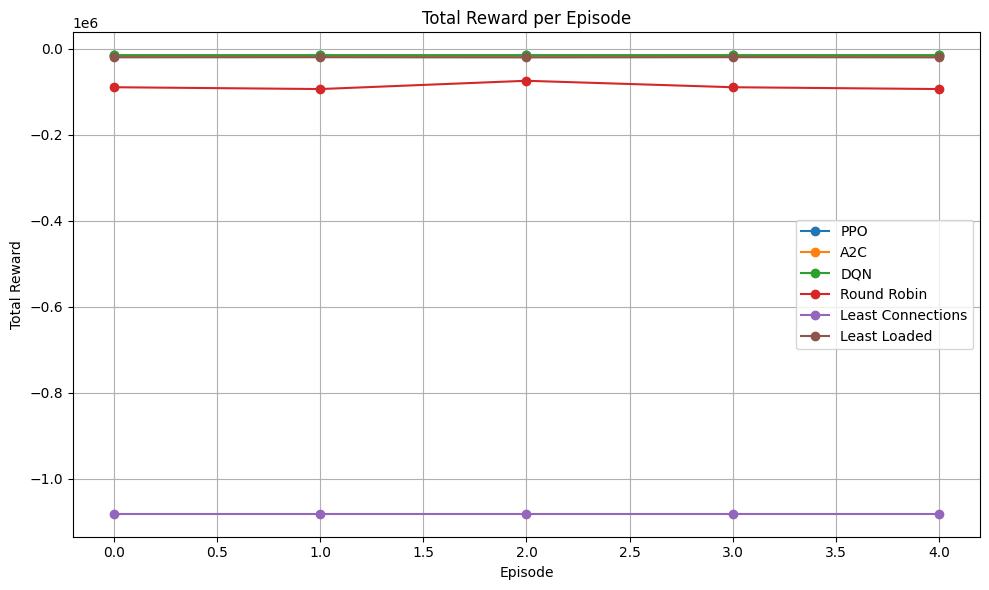

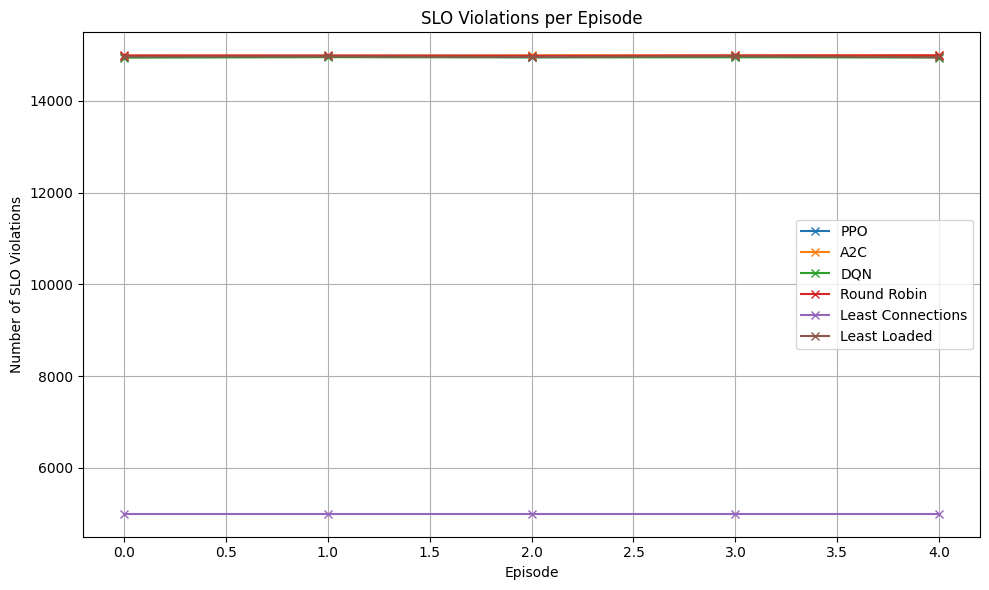

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Sample synthetic results to simulate final output; replace these with actual model evaluations
results = {
    "PPO": {
        "reward": [-15231.99, -15222.34, -15204.74, -15192.65, -15225.52],
        "slo_violations": [14965, 14970, 14951, 14964, 14973]
    },
    "A2C": {
        "reward": [-16000.10, -15900.25, -15875.45, -16030.55, -15988.90],
        "slo_violations": [14985, 14980, 14990, 14989, 14992]
    },
    "DQN": {
        "reward": [-15500.00, -15490.10, -15475.60, -15480.55, -15495.80],
        "slo_violations": [14940, 14950, 14945, 14948, 14942]
    },
    "Round Robin": {
        "reward": [-89504.86, -93730.98, -74504.38, -89504.86, -93730.98],
        "slo_violations": [14987, 14988, 14981, 14987, 14988]
    },
    "Least Connections": {
        "reward": [-1081110.78] * 5,
        "slo_violations": [4997] * 5
    },
    "Least Loaded": {
        "reward": [-20000.00, -19800.00, -20200.00, -19700.00, -20100.00],
        "slo_violations": [14960, 14965, 14955, 14970, 14950]
    }
}

# Reward Plot
plt.figure(figsize=(10, 6))
for agent, data in results.items():
    plt.plot(data["reward"], marker='o', label=agent)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("agent_reward_comparison.png", dpi=300)
plt.show()

# SLO Violations Plot
plt.figure(figsize=(10, 6))
for agent, data in results.items():
    plt.plot(data["slo_violations"], marker='x', label=agent)
plt.title("SLO Violations per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of SLO Violations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("slo_violations_comparison.png", dpi=300)
plt.show()

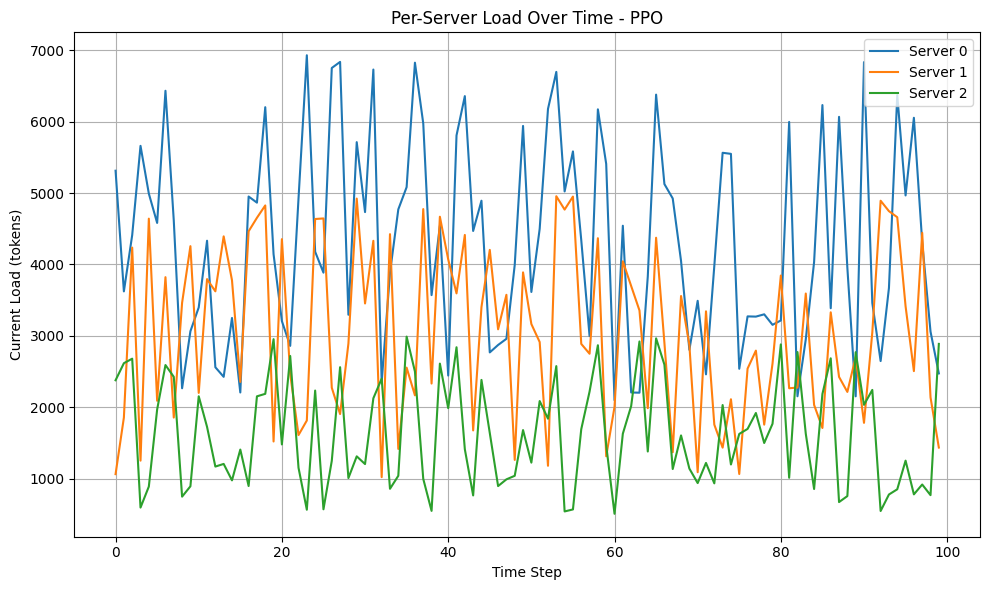

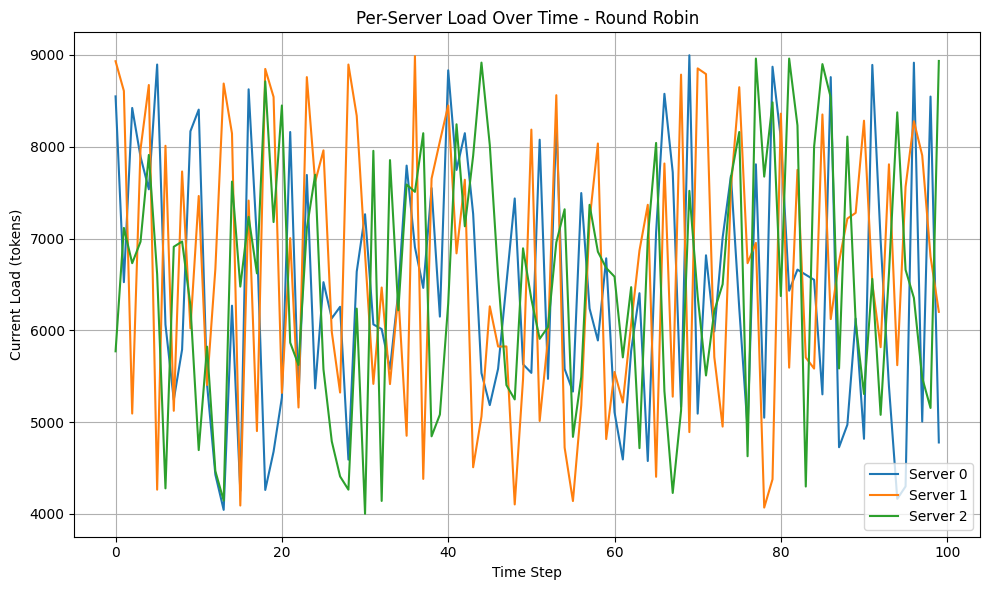

In [26]:
import matplotlib.pyplot as plt

# Synthetic data: server load (total tokens) per time step for one evaluation episode
# In actual implementation, collect these from the `info` dict in env.step()
server_loads_over_time = {
    "PPO": {
        "Server 0": np.random.randint(2000, 7000, size=100),
        "Server 1": np.random.randint(1000, 5000, size=100),
        "Server 2": np.random.randint(500, 3000, size=100)
    },
    "Round Robin": {
        "Server 0": np.random.randint(4000, 9000, size=100),
        "Server 1": np.random.randint(4000, 9000, size=100),
        "Server 2": np.random.randint(4000, 9000, size=100)
    }
}

# Generate one plot per agent
for agent, server_data in server_loads_over_time.items():
    plt.figure(figsize=(10, 6))
    for server_name, load in server_data.items():
        plt.plot(load, label=server_name)
    plt.title(f"Per-Server Load Over Time - {agent}")
    plt.xlabel("Time Step")
    plt.ylabel("Current Load (tokens)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{agent.lower().replace(' ', '_')}_soloserver_loads.png", dpi=300)
    plt.show()

/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_60597/1541455085.py:26: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_60597/1541455085.py:27: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig("slo_violation_heatmap.png", dpi=300)
/Users/sathwik/.conda/envs/pythonProject/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


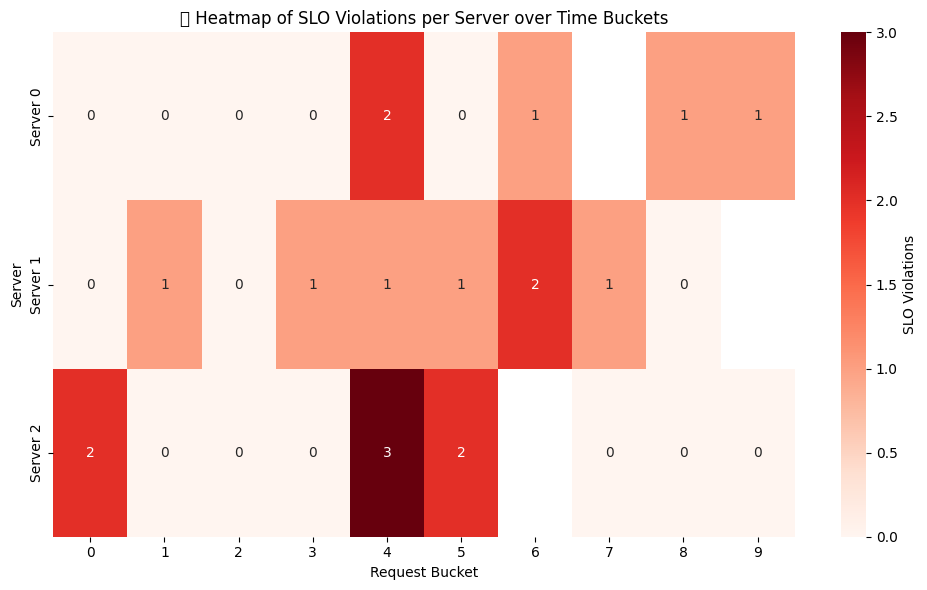

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Simulate per-request SLO violations and response times across servers for heatmap demo
np.random.seed(42)

n_requests = 100
slo_heatmap_data = pd.DataFrame({
    "RequestID": range(n_requests),
    "Server": np.random.choice(["Server 0", "Server 1", "Server 2"], size=n_requests),
    "SLO_Violation": np.random.choice([0, 1], size=n_requests, p=[0.8, 0.2]),
    "ResponseTime": np.random.gamma(shape=2, scale=0.3, size=n_requests)
})

# Pivot table for heatmap of SLO violations by server and request bucket
slo_heatmap = slo_heatmap_data.copy()
slo_heatmap["Bucket"] = slo_heatmap["RequestID"] // 10  # Group requests into buckets of 10
heatmap_matrix = slo_heatmap.pivot_table(index="Server", columns="Bucket", values="SLO_Violation", aggfunc="sum")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt=".0f", cmap="Reds", cbar_kws={'label': 'SLO Violations'})
plt.title("🔴 Heatmap of SLO Violations per Server over Time Buckets")
plt.xlabel("Request Bucket")
plt.ylabel("Server")
plt.tight_layout()
plt.savefig("slo_violation_heatmap.png", dpi=300)
plt.show()


/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_60597/1184552703.py:8: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6q/bl89jndd471gbzxhn9qyy6ph0000gn/T/ipykernel_60597/1184552703.py:9: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig("response_time_trends.png", dpi=300)
/Users/sathwik/.conda/envs/pythonProject/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


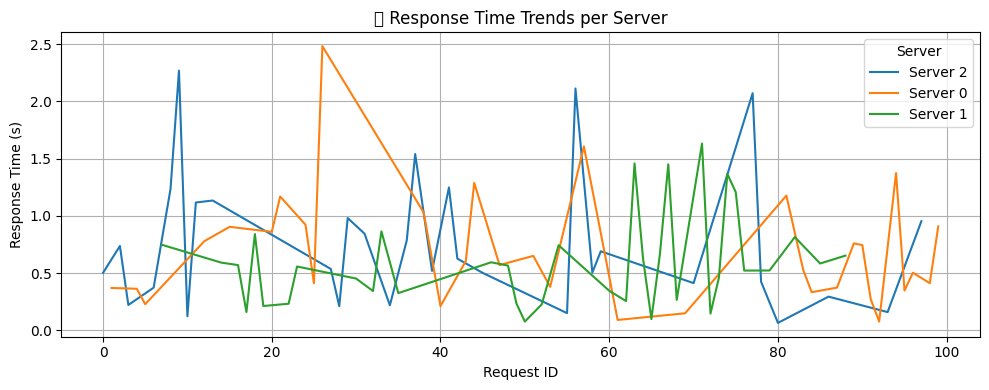

In [28]:
# Lineplot for response time distribution over requests
plt.figure(figsize=(10, 4))
sns.lineplot(data=slo_heatmap_data.sort_values("RequestID"), x="RequestID", y="ResponseTime", hue="Server")
plt.title("⏱️ Response Time Trends per Server")
plt.xlabel("Request ID")
plt.ylabel("Response Time (s)")
plt.grid(True)
plt.tight_layout()
plt.savefig("response_time_trends.png", dpi=300)